# Neural Network Project

*DSE student*, 
*Daria Shcherbakova*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import random
import glob
import os
from PIL import Image

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import zero_one_loss, roc_curve, auc, confusion_matrix
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, StratifiedKFold

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
from keras_tuner import HyperModel, Hyperband, RandomSearch, Objective, HyperParameters

2023-08-01 10:25:31.295207: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Data processing

In [2]:
train_dir = '/Users/svesh1971/Desktop/UNIMI/ML/train'
test_dir = '/Users/svesh1971/Desktop/UNIMI/ML/test'

train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

print("Train images:")
print(train_files)

print("\nTest images:")
print(test_files)

Train images:
['chihuahua', 'muffin']

Test images:
['chihuahua', 'muffin']


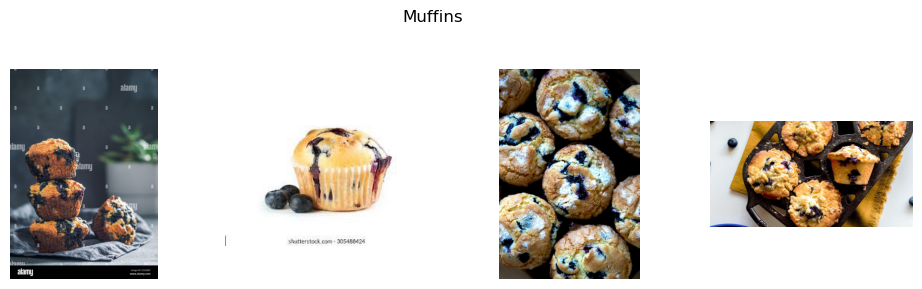

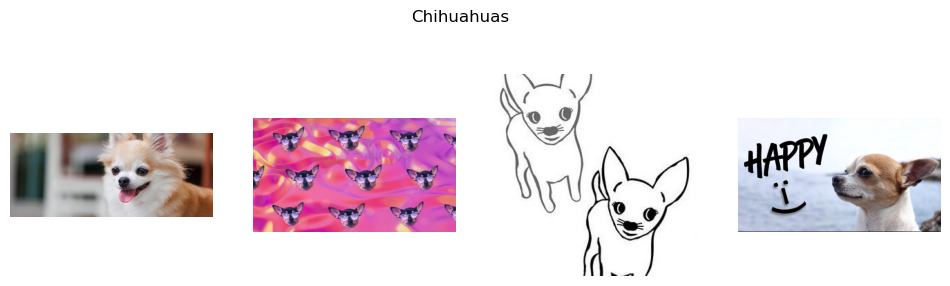

In [3]:
muffin = glob.glob(train_dir + "/muffin/*.jpg")
dog = glob.glob(train_dir + "/chihuahua/*.jpg")


if len(muffin) >= 4 & len(dog) >= 4:
    muffin = random.sample(muffin, 4)
    dog = random.sample(dog, 4)

    plt.figure(figsize=(12, 6))
    for i, path in enumerate(muffin):
        img = mpimg.imread(path)
        plt.subplot(2, 4, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle('Muffins')
    plt.show()

    plt.figure(figsize=(12, 6))
    for i, path in enumerate(dog):
        img = mpimg.imread(path)
        plt.subplot(2, 4, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle('Chihuahuas')
    plt.show()

In [4]:
image_size = (64, 64)

In [5]:
def preprocess_image(image_path):
    with Image.open(image_path) as image:
        image = image.convert("RGB")
        image = image.resize(image_size)
        image_array = np.array(image)
        return image_array

In [6]:
def load_images(directory):
    X = []
    y = []
    categories = os.listdir(directory)
    for category in categories:
        category_dir = os.path.join(directory, category)
        if os.path.isdir(category_dir):
            for image_name in os.listdir(category_dir):
                image_path = os.path.join(category_dir, image_name)
                if os.path.isfile(image_path):
                    image_array = preprocess_image(image_path)
                    X.append(image_array)
                    label = 1 if category == 'chihuahua' else 0
                    y.append(label)
    X = np.array(X)
    y = np.array(y)
    return X, y

In [7]:
X_train, y_train = load_images(train_dir)
X_test, y_test = load_images(test_dir)

In [8]:
print("\nImage Format")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


Image Format
X_train shape: (4733, 64, 64, 3)
X_test shape: (1184, 64, 64, 3)


In [9]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [10]:
print("\nPixel Value Range")
print("X_train min:", np.min(X_train))
print("X_train max:", np.max(X_train))
print("X_test min:", np.min(X_test))  
print("X_test max:", np.max(X_test))


Pixel Value Range
X_train min: 0.0
X_train max: 1.0
X_test min: 0.0
X_test max: 1.0


## CNN

### The first architecture

In [11]:
# feature extraction
model0 = Sequential()
model0.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)))
model0.add(MaxPool2D((2, 2)))
# classification
model0.add(Flatten())
model0.add(Dense(1, activation='sigmoid'))

In [12]:
model0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 30752)             0         
                                                                 
 dense (Dense)               (None, 1)                 30753     
                                                                 
Total params: 31649 (123.63 KB)
Trainable params: 31649 (123.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
model0.compile(optimizer="adam",
              loss='binary_crossentropy', 
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [14]:
X_train1, X_validation, y_train1, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [15]:
history0 = model0.fit(X_train1, y_train1, epochs=10, batch_size=32, verbose=1,
                      validation_data = (X_validation, y_validation))

Epoch 1/10
119/119 [==============================] - 8s 60ms/step - loss: 0.5745 - accuracy: 0.7137 - precision: 0.7359 - recall: 0.7402 - val_loss: 0.4386 - val_accuracy: 0.8110 - val_precision: 0.7877 - val_recall: 0.8750
Epoch 2/10
119/119 [==============================] - 6s 48ms/step - loss: 0.4013 - accuracy: 0.8286 - precision: 0.8329 - recall: 0.8575 - val_loss: 0.4093 - val_accuracy: 0.8089 - val_precision: 0.8621 - val_recall: 0.7560
Epoch 3/10
119/119 [==============================] - 6s 49ms/step - loss: 0.3626 - accuracy: 0.8389 - precision: 0.8468 - recall: 0.8599 - val_loss: 0.3853 - val_accuracy: 0.8321 - val_precision: 0.9021 - val_recall: 0.7621
Epoch 4/10
119/119 [==============================] - 7s 57ms/step - loss: 0.3074 - accuracy: 0.8769 - precision: 0.8852 - recall: 0.8895 - val_loss: 0.3467 - val_accuracy: 0.8585 - val_precision: 0.8620 - val_recall: 0.8690
Epoch 5/10
119/119 [==============================] - 6s 54ms/step - loss: 0.2896 - accuracy: 0.8848

In [16]:
train_loss, train_accuracy, train_precision, train_recall = model0.evaluate(X_train1, y_train1, verbose=0)

In [17]:
print(f'Train Loss: {train_loss:.4f}')
print(f'Train Accuracy: {train_accuracy:.4f}')
print(f'Train Precision: {train_precision:.4f}')
print(f'Train Recall: {train_recall:.4f}')

Train Loss: 0.1453
Train Accuracy: 0.9599
Train Precision: 0.9614
Train Recall: 0.9651


In [18]:
validation_loss, validation_accuracy, validation_precision, validation_recall = model0.evaluate(X_validation, y_validation, verbose=0)

In [19]:
print(f'validation Loss: {validation_loss:.4f}')
print(f'validation Accuracy: {validation_accuracy:.4f}')
print(f'validation Precision: {validation_precision:.4f}')
print(f'validation Recall: {validation_recall:.4f}')

validation Loss: 0.3449
validation Accuracy: 0.8627
validation Precision: 0.8547
validation Recall: 0.8891


*change learning rate*

In [20]:
# feature extraction
model01 = Sequential()
model01.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)))
model01.add(MaxPool2D((2, 2)))
# classification
model01.add(Flatten())
model01.add(Dense(1, activation='sigmoid'))

In [21]:
model01.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy', 
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [22]:
history01 = model01.fit(X_train1, y_train1, epochs=30, batch_size=32, verbose=1,  validation_data = (X_validation, y_validation))

Epoch 1/30
119/119 [==============================] - 7s 51ms/step - loss: 0.6568 - accuracy: 0.5993 - precision_1: 0.6154 - recall_1: 0.7058 - val_loss: 0.6022 - val_accuracy: 0.7413 - val_precision_1: 0.8039 - val_recall_1: 0.6694
Epoch 2/30
119/119 [==============================] - 6s 49ms/step - loss: 0.5695 - accuracy: 0.7446 - precision_1: 0.7673 - recall_1: 0.7625 - val_loss: 0.5623 - val_accuracy: 0.7075 - val_precision_1: 0.6562 - val_recall_1: 0.9274
Epoch 3/30
119/119 [==============================] - 7s 59ms/step - loss: 0.5096 - accuracy: 0.7742 - precision_1: 0.7949 - recall_1: 0.7891 - val_loss: 0.5081 - val_accuracy: 0.7614 - val_precision_1: 0.7163 - val_recall_1: 0.9012
Epoch 4/30
119/119 [==============================] - 7s 59ms/step - loss: 0.4695 - accuracy: 0.8051 - precision_1: 0.8171 - recall_1: 0.8274 - val_loss: 0.4610 - val_accuracy: 0.8068 - val_precision_1: 0.7861 - val_recall_1: 0.8669
Epoch 5/30
119/119 [==============================] - 7s 56ms/step -

In [23]:
train_loss, train_accuracy, train_precision, train_recall = model01.evaluate(X_train1, y_train1, verbose=0)

In [24]:
print(f'Train Loss: {train_loss:.4f}')
print(f'Train Accuracy: {train_accuracy:.4f}')
print(f'Train Precision: {train_precision:.4f}')
print(f'Train Recall: {train_recall:.4f}')

Train Loss: 0.2585
Train Accuracy: 0.9052
Train Precision: 0.8834
Train Recall: 0.9515


In [25]:
validation_loss, validation_accuracy, validation_precision, validation_recall = model01.evaluate(X_validation, y_validation, verbose=0)

In [26]:
print(f'validation Loss: {validation_loss:.4f}')
print(f'validation Accuracy: {validation_accuracy:.4f}')
print(f'validation Precision: {validation_precision:.4f}')
print(f'validation Recall: {validation_recall:.4f}')

validation Loss: 0.3479
validation Accuracy: 0.8617
validation Precision: 0.8253
validation Recall: 0.9335


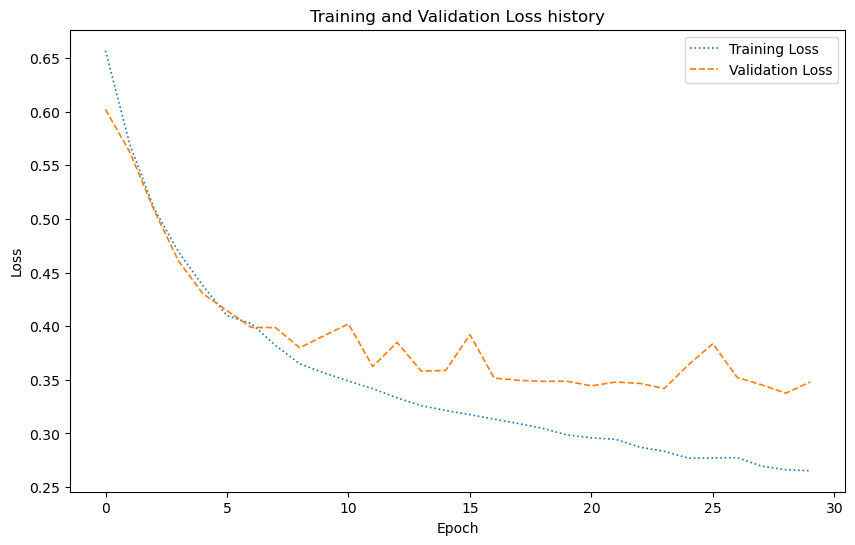

In [27]:
train_loss_history = history01.history['loss']
validation_loss_history = history01.history['val_loss']


plt.figure(figsize=(10, 6))

plt.plot(train_loss_history, label='Training Loss', linestyle=':', linewidth=1.2)
plt.plot(validation_loss_history, label='Validation Loss', linestyle='--', linewidth=1.2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss history')
plt.legend()
plt.grid(False)
plt.show()

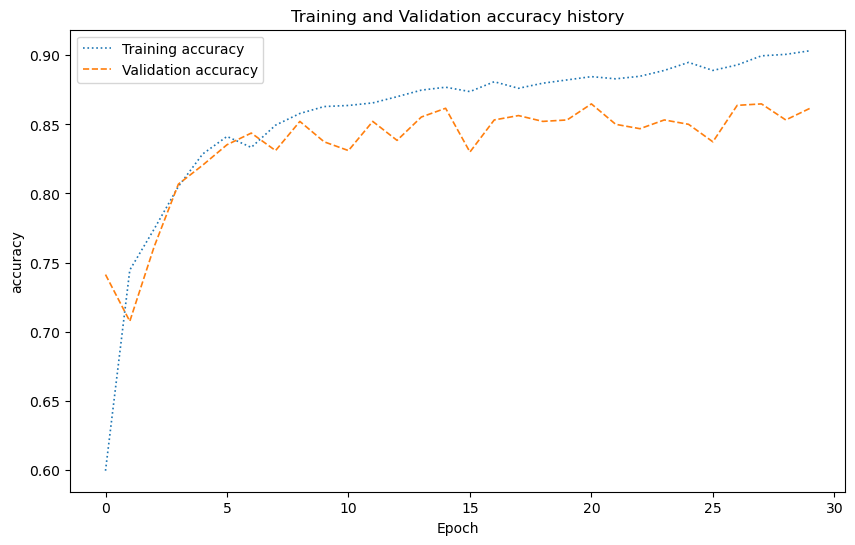

In [28]:
train_accuracy_history = history01.history['accuracy']
validation_accuracy_history = history01.history['val_accuracy']


plt.figure(figsize=(10, 6))

plt.plot(train_accuracy_history, label='Training accuracy', linestyle=':', linewidth=1.2)
plt.plot(validation_accuracy_history, label='Validation accuracy', linestyle='--', linewidth=1.2)
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.title('Training and Validation accuracy history')
plt.legend()
plt.grid(False)
plt.show()

#### 5-fold cross-validation

In [29]:
def create_model(image_size):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)))
    model.add(MaxPool2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

In [30]:
def zero_one_loss(y_true, y_pred):
    return tf.math.reduce_mean(tf.math.abs(y_true - tf.round(y_pred)))

In [31]:
kfold = StratifiedKFold(n_splits=5, shuffle=True)
histories = []

for fold, (train_indices, val_indices) in enumerate(kfold.split(X_train, y_train)):
    print(f"Training on Fold {fold+1}...")
    X_train_fold = X_train[train_indices]
    y_train_fold = y_train[train_indices]
    X_val_fold = X_train[val_indices]
    y_val_fold = y_train[val_indices]


    model = create_model(image_size)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), zero_one_loss])

    history = model.fit(X_train_fold, y_train_fold, epochs=15, batch_size=32, verbose=1,
                        validation_data= (X_val_fold, y_val_fold))
    histories.append(history)

Training on Fold 1...
Epoch 1/15
119/119 [==============================] - 7s 54ms/step - loss: 0.6237 - accuracy: 0.6601 - precision_2: 0.6713 - recall_2: 0.7274 - zero_one_loss: 0.3397 - val_loss: 0.5763 - val_accuracy: 0.7138 - val_precision_2: 0.7331 - val_recall_2: 0.7402 - val_zero_one_loss: 0.2894
Epoch 2/15
119/119 [==============================] - 7s 56ms/step - loss: 0.5384 - accuracy: 0.7409 - precision_2: 0.7575 - recall_2: 0.7660 - zero_one_loss: 0.2582 - val_loss: 0.5278 - val_accuracy: 0.7561 - val_precision_2: 0.7827 - val_recall_2: 0.7598 - val_zero_one_loss: 0.2463
Epoch 3/15
119/119 [==============================] - 7s 62ms/step - loss: 0.4963 - accuracy: 0.7771 - precision_2: 0.7924 - recall_2: 0.7963 - zero_one_loss: 0.2222 - val_loss: 0.4958 - val_accuracy: 0.7867 - val_precision_2: 0.8016 - val_recall_2: 0.8047 - val_zero_one_loss: 0.2147
Epoch 4/15
119/119 [==============================] - 6s 54ms/step - loss: 0.4625 - accuracy: 0.7961 - precision_2: 0.8049 

119/119 [==============================] - 6s 49ms/step - loss: 0.3133 - accuracy: 0.8772 - precision_3: 0.8770 - recall_3: 0.8989 - zero_one_loss: 0.1221 - val_loss: 0.3499 - val_accuracy: 0.8479 - val_precision_3: 0.8849 - val_recall_3: 0.8262 - val_zero_one_loss: 0.1521
Epoch 15/15
119/119 [==============================] - 7s 59ms/step - loss: 0.3079 - accuracy: 0.8788 - precision_3: 0.8795 - recall_3: 0.8989 - zero_one_loss: 0.1211 - val_loss: 0.3594 - val_accuracy: 0.8437 - val_precision_3: 0.8991 - val_recall_3: 0.8008 - val_zero_one_loss: 0.1563
Training on Fold 3...
Epoch 1/15
119/119 [==============================] - 9s 68ms/step - loss: 0.6291 - accuracy: 0.6524 - precision_4: 0.6611 - recall_4: 0.7328 - zero_one_loss: 0.3479 - val_loss: 0.5779 - val_accuracy: 0.7233 - val_precision_4: 0.7706 - val_recall_4: 0.6953 - val_zero_one_loss: 0.2736
Epoch 2/15
119/119 [==============================] - 6s 48ms/step - loss: 0.5449 - accuracy: 0.7448 - precision_4: 0.7664 - recall_4

Epoch 13/15
119/119 [==============================] - 8s 69ms/step - loss: 0.3367 - accuracy: 0.8746 - precision_5: 0.8790 - recall_5: 0.8906 - zero_one_loss: 0.1257 - val_loss: 0.3546 - val_accuracy: 0.8510 - val_precision_5: 0.8295 - val_recall_5: 0.9121 - val_zero_one_loss: 0.1509
Epoch 14/15
119/119 [==============================] - 6s 48ms/step - loss: 0.3335 - accuracy: 0.8706 - precision_5: 0.8709 - recall_5: 0.8930 - zero_one_loss: 0.1292 - val_loss: 0.3426 - val_accuracy: 0.8584 - val_precision_5: 0.8706 - val_recall_5: 0.8672 - val_zero_one_loss: 0.1436
Epoch 15/15
119/119 [==============================] - 5s 46ms/step - loss: 0.3260 - accuracy: 0.8764 - precision_5: 0.8776 - recall_5: 0.8964 - zero_one_loss: 0.1239 - val_loss: 0.3380 - val_accuracy: 0.8584 - val_precision_5: 0.8720 - val_recall_5: 0.8652 - val_zero_one_loss: 0.1436
Training on Fold 5...
Epoch 1/15
119/119 [==============================] - 6s 48ms/step - loss: 0.6504 - accuracy: 0.6184 - precision_6: 0.61

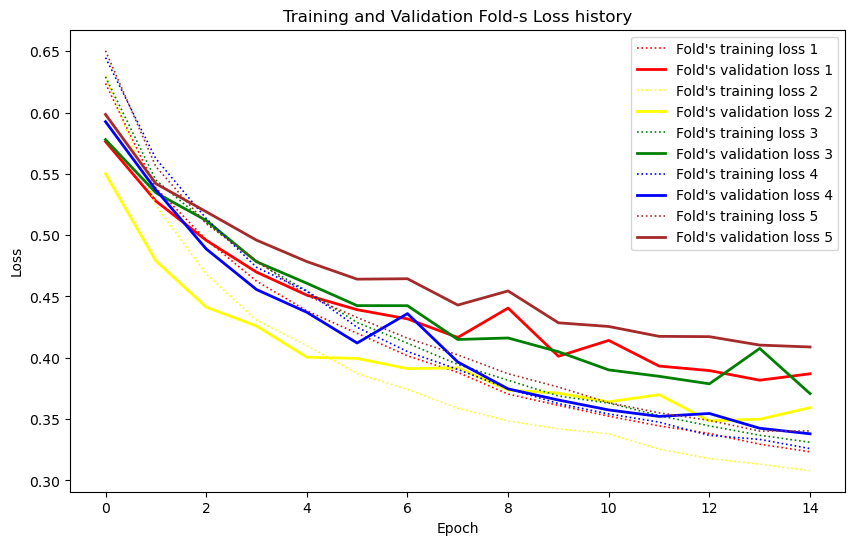

In [32]:
train_accuracies = []
validation_accuracies = []
colors = ['red', 'yellow', 'green', 'blue', 'brown']
i = 1
plt.figure(figsize=(10, 6))

for (history, color) in zip(histories, colors):
    plt.plot(history.history["loss"], label="Fold's training loss " + str(i) , linestyle=':', linewidth=1.2,color=color)
    plt.plot(history.history["val_loss"], label="Fold's validation loss " + str(i) , linestyle='-', linewidth=2,color=color)
    i += 1

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Fold-s Loss history')
plt.legend()
plt.grid(False)
plt.show()

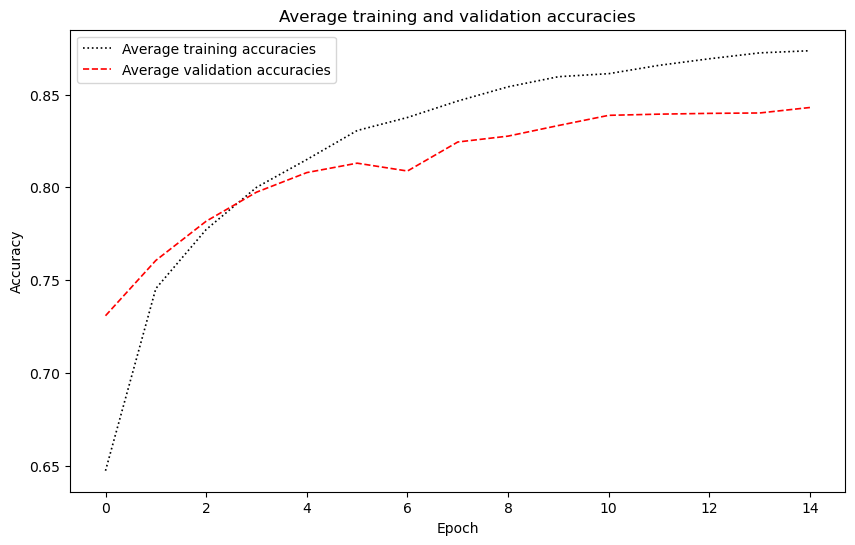

In [33]:
train_accuracies = []
validation_accuracies = []

for history in histories:
    train_accuracies.append(history.history['accuracy'])
    validation_accuracies.append(history.history['val_accuracy'])

matrix = np.array(train_accuracies)
train_mean_accuracies = np.mean(matrix, axis = 0)

matrix_val = np.array(validation_accuracies)
validation_mean_accuracies = np.mean(matrix_val, axis = 0)

plt.figure(figsize=(10, 6))

plt.plot(train_mean_accuracies, label='Average training accuracies', linestyle=':', linewidth=1.2,color='black')
plt.plot(validation_mean_accuracies, label='Average validation accuracies', linestyle='--', linewidth=1.2,color='red')


plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Average training and validation accuracies')
plt.legend()
plt.grid(False)
plt.show()

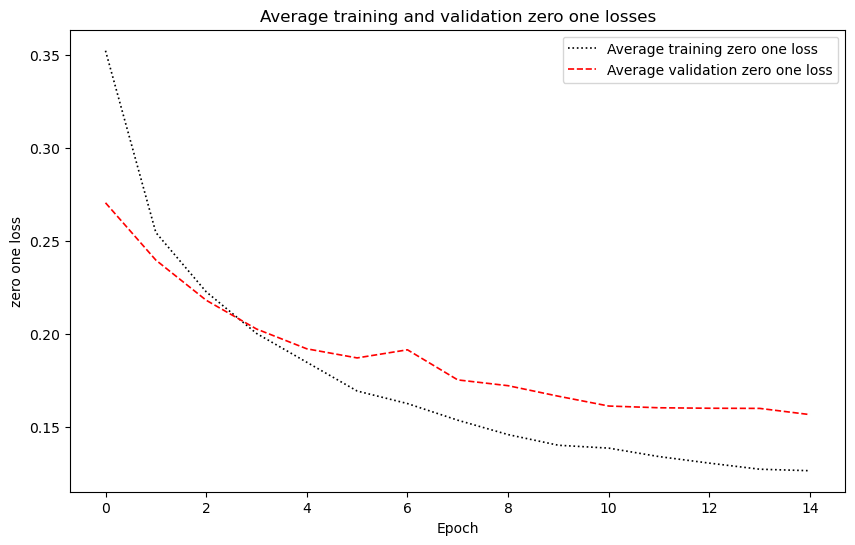

In [34]:
train_zero_one_losses = []
validation_zero_one_losses = []

for history in histories:
    train_zero_one_losses.append(history.history['zero_one_loss'])
    validation_zero_one_losses.append(history.history['val_zero_one_loss'])

matrix = np.array(train_zero_one_losses)
train_mean_loss = np.mean(matrix, axis = 0)

matrix_val = np.array(validation_zero_one_losses)
validation_mean_loss = np.mean(matrix_val, axis = 0)

plt.figure(figsize=(10, 6))

plt.plot(train_mean_loss, label='Average training zero one loss', linestyle=':', linewidth=1.2,color='black')
plt.plot(validation_mean_loss, label='Average validation zero one loss', linestyle='--', linewidth=1.2,color='red')


plt.xlabel('Epoch')
plt.ylabel('zero one loss')
plt.title('Average training and validation zero one losses')
plt.legend()
plt.grid(False)
plt.show()

### The second architecture

In [35]:
# feature extraction
model1 = Sequential()
model1.add(Conv2D(32, (5, 5), activation='relu', input_shape=(image_size[0], image_size[1], 3)))
model1.add(MaxPool2D(pool_size=(2, 2)))
model1.add(Conv2D(16, (3, 3), activation='relu'))
model1.add(MaxPool2D(pool_size=(2, 2)))
# classification
model1.add(Flatten())
model1.add(Dense(128, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))

In [36]:
model1.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 60, 60, 32)        2432      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 16)        4624      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 14, 14, 16)        0         
 g2D)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 3136)              0         
                                                                 
 dense_7 (Dense)             (None, 128)              

In [37]:
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy', 
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [38]:
history1 = model1.fit(X_train1, y_train1, epochs=15, batch_size=32, verbose=1,  validation_data = (X_validation, y_validation))

Epoch 1/15
119/119 [==============================] - 14s 107ms/step - loss: 0.6361 - accuracy: 0.6490 - precision_7: 0.6505 - recall_7: 0.7688 - val_loss: 0.5756 - val_accuracy: 0.6674 - val_precision_7: 0.6225 - val_recall_7: 0.9274
Epoch 2/15
119/119 [==============================] - 13s 107ms/step - loss: 0.5253 - accuracy: 0.7546 - precision_7: 0.7652 - recall_7: 0.7930 - val_loss: 0.4509 - val_accuracy: 0.8268 - val_precision_7: 0.8388 - val_recall_7: 0.8286
Epoch 3/15
119/119 [==============================] - 15s 123ms/step - loss: 0.4537 - accuracy: 0.7966 - precision_7: 0.8149 - recall_7: 0.8110 - val_loss: 0.4232 - val_accuracy: 0.8131 - val_precision_7: 0.7784 - val_recall_7: 0.8992
Epoch 4/15
119/119 [==============================] - 12s 102ms/step - loss: 0.4018 - accuracy: 0.8278 - precision_7: 0.8407 - recall_7: 0.8439 - val_loss: 0.3787 - val_accuracy: 0.8405 - val_precision_7: 0.8678 - val_recall_7: 0.8206
Epoch 5/15
119/119 [==============================] - 13s 10

In [39]:
train_loss, train_accuracy, train_precision, train_recall = model1.evaluate(X_train1, y_train1, verbose=0)

In [40]:
print(f'Train Loss: {train_loss:.4f}')
print(f'Train Accuracy: {train_accuracy:.4f}')
print(f'Train Precision: {train_precision:.4f}')
print(f'Train Recall: {train_recall:.4f}')

Train Loss: 0.2400
Train Accuracy: 0.9062
Train Precision: 0.9078
Train Recall: 0.9215


In [41]:
validation_loss, validation_accuracy, validation_precision, validation_recall = model1.evaluate(X_validation, y_validation, verbose=0)

In [42]:
print(f'validation Loss: {validation_loss:.4f}')
print(f'validation Accuracy: {validation_accuracy:.4f}')
print(f'validation Precision: {validation_precision:.4f}')
print(f'validation Recall: {validation_recall:.4f}')

validation Loss: 0.3037
validation Accuracy: 0.8796
validation Precision: 0.8631
validation Recall: 0.9153


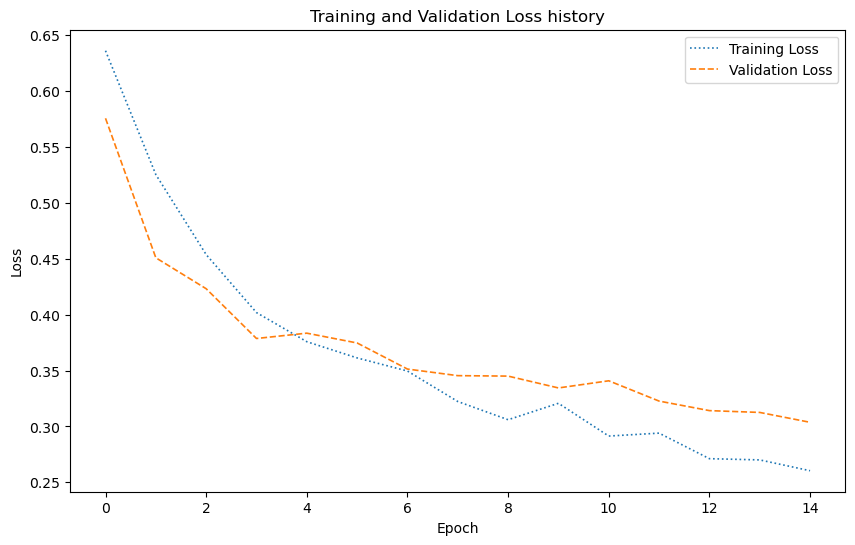

In [43]:
train_loss_history = history1.history['loss']
validation_loss_history = history1.history['val_loss']


plt.figure(figsize=(10, 6))

plt.plot(train_loss_history, label='Training Loss', linestyle=':', linewidth=1.2)
plt.plot(validation_loss_history, label='Validation Loss', linestyle='--', linewidth=1.2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss history')
plt.legend()
plt.grid(False)
plt.show()

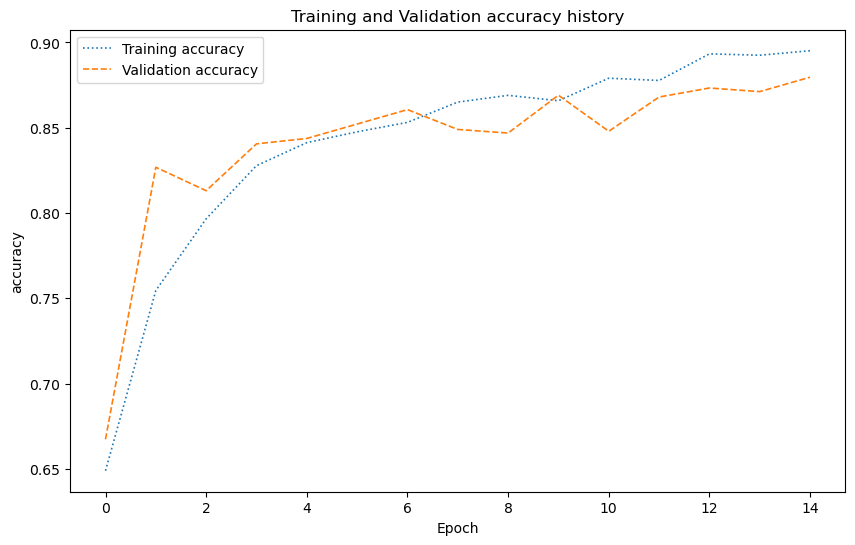

In [44]:
train_accuracy_history = history1.history['accuracy']
validation_accuracy_history = history1.history['val_accuracy']


plt.figure(figsize=(10, 6))

plt.plot(train_accuracy_history, label='Training accuracy', linestyle=':', linewidth=1.2)
plt.plot(validation_accuracy_history, label='Validation accuracy', linestyle='--', linewidth=1.2)
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.title('Training and Validation accuracy history')
plt.legend()
plt.grid(False)
plt.show()

#### 5-fold cross-validation

In [45]:
def create_model(image_size):
    model = Sequential()
    model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(image_size[0], image_size[1], 3)))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(16, (3, 3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    # classification
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [46]:
histories = []

for fold, (train_indices, val_indices) in enumerate(kfold.split(X_train, y_train)):
    print(f"Training on Fold {fold+1}...")
    X_train_fold = X_train[train_indices]
    y_train_fold = y_train[train_indices]
    X_val_fold = X_train[val_indices]
    y_val_fold = y_train[val_indices]


    model = create_model(image_size)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), zero_one_loss])

    history = model.fit(X_train_fold, y_train_fold, epochs=15, batch_size=32, verbose=1,
                        validation_data= (X_val_fold, y_val_fold))
    histories.append(history)

Training on Fold 1...
Epoch 1/15
119/119 [==============================] - 14s 112ms/step - loss: 0.5839 - accuracy: 0.6894 - precision_8: 0.6880 - recall_8: 0.7787 - zero_one_loss: 0.3100 - val_loss: 0.4943 - val_accuracy: 0.7687 - val_precision_8: 0.7522 - val_recall_8: 0.8535 - val_zero_one_loss: 0.2338
Epoch 2/15
119/119 [==============================] - 12s 102ms/step - loss: 0.4631 - accuracy: 0.7953 - precision_8: 0.8149 - recall_8: 0.8041 - zero_one_loss: 0.2047 - val_loss: 0.4801 - val_accuracy: 0.7592 - val_precision_8: 0.9303 - val_recall_8: 0.5996 - val_zero_one_loss: 0.2382
Epoch 3/15
119/119 [==============================] - 14s 117ms/step - loss: 0.4195 - accuracy: 0.8217 - precision_8: 0.8359 - recall_8: 0.8339 - zero_one_loss: 0.1778 - val_loss: 0.3887 - val_accuracy: 0.8405 - val_precision_8: 0.8336 - val_recall_8: 0.8809 - val_zero_one_loss: 0.1601
Epoch 4/15
119/119 [==============================] - 12s 99ms/step - loss: 0.3800 - accuracy: 0.8399 - precision_8: 

119/119 [==============================] - 12s 101ms/step - loss: 0.2838 - accuracy: 0.8809 - precision_9: 0.8855 - recall_9: 0.8955 - zero_one_loss: 0.1196 - val_loss: 0.3511 - val_accuracy: 0.8501 - val_precision_9: 0.8715 - val_recall_9: 0.8477 - val_zero_one_loss: 0.1508
Epoch 15/15
119/119 [==============================] - 15s 123ms/step - loss: 0.2741 - accuracy: 0.8885 - precision_9: 0.8901 - recall_9: 0.9057 - zero_one_loss: 0.1120 - val_loss: 0.3515 - val_accuracy: 0.8416 - val_precision_9: 0.8740 - val_recall_9: 0.8262 - val_zero_one_loss: 0.1591
Training on Fold 3...
Epoch 1/15
119/119 [==============================] - 13s 101ms/step - loss: 0.6078 - accuracy: 0.6651 - precision_10: 0.6709 - recall_10: 0.7469 - zero_one_loss: 0.3341 - val_loss: 0.5251 - val_accuracy: 0.7550 - val_precision_10: 0.8125 - val_recall_10: 0.7109 - val_zero_one_loss: 0.2445
Epoch 2/15
119/119 [==============================] - 11s 96ms/step - loss: 0.4895 - accuracy: 0.7731 - precision_10: 0.804

119/119 [==============================] - 14s 118ms/step - loss: 0.2889 - accuracy: 0.8772 - precision_11: 0.8825 - recall_11: 0.8915 - zero_one_loss: 0.1221 - val_loss: 0.3355 - val_accuracy: 0.8615 - val_precision_11: 0.8313 - val_recall_11: 0.9336 - val_zero_one_loss: 0.1389
Epoch 13/15
119/119 [==============================] - 11s 95ms/step - loss: 0.2827 - accuracy: 0.8804 - precision_11: 0.8850 - recall_11: 0.8950 - zero_one_loss: 0.1200 - val_loss: 0.3153 - val_accuracy: 0.8732 - val_precision_11: 0.8755 - val_recall_11: 0.8926 - val_zero_one_loss: 0.1258
Epoch 14/15
119/119 [==============================] - 12s 102ms/step - loss: 0.2689 - accuracy: 0.8894 - precision_11: 0.8932 - recall_11: 0.9033 - zero_one_loss: 0.1100 - val_loss: 0.3392 - val_accuracy: 0.8605 - val_precision_11: 0.8253 - val_recall_11: 0.9414 - val_zero_one_loss: 0.1399
Epoch 15/15
119/119 [==============================] - 11s 95ms/step - loss: 0.2663 - accuracy: 0.8896 - precision_11: 0.8940 - recall_11

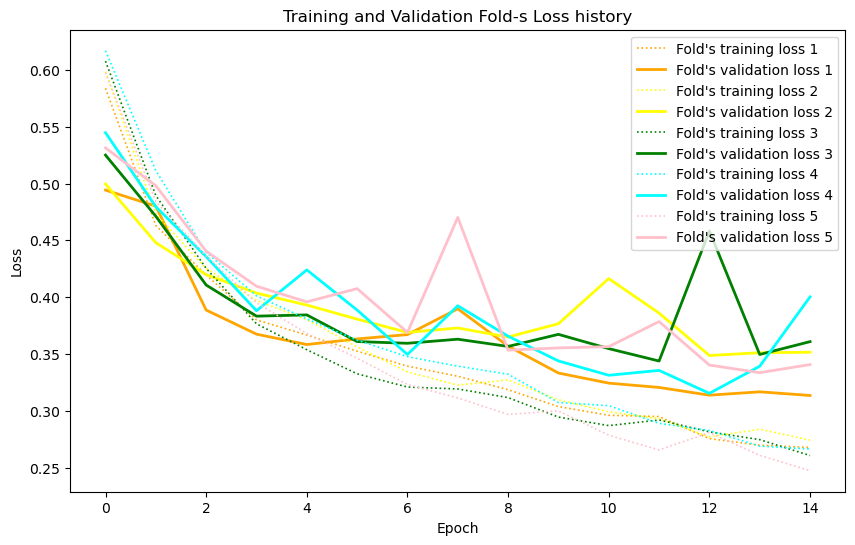

In [47]:
train_accuracies = []
validation_accuracies = []
colors = ['orange', 'yellow', 'green', 'cyan', 'pink']
i = 1
plt.figure(figsize=(10, 6))

for (history, color) in zip(histories, colors):
    plt.plot(history.history["loss"], label="Fold's training loss " + str(i) , linestyle=':', linewidth=1.2,color=color)
    plt.plot(history.history["val_loss"], label="Fold's validation loss " + str(i) , linestyle='-', linewidth=2,color=color)
    i += 1

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Fold-s Loss history')
plt.legend()
plt.grid(False)
plt.show()

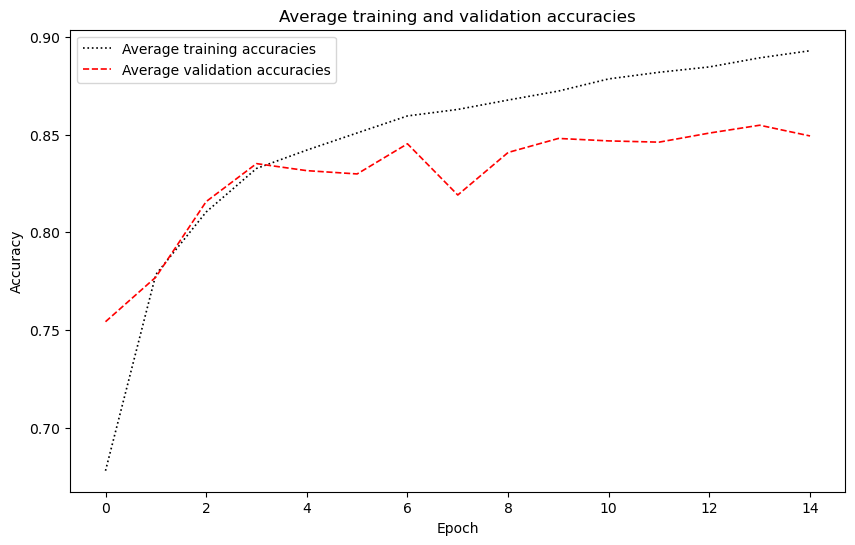

In [48]:
train_accuracies = []
validation_accuracies = []

for history in histories:
    train_accuracies.append(history.history['accuracy'])
    validation_accuracies.append(history.history['val_accuracy'])

matrix = np.array(train_accuracies)
train_mean_accuracies = np.mean(matrix, axis = 0)

matrix_val = np.array(validation_accuracies)
validation_mean_accuracies = np.mean(matrix_val, axis = 0)

plt.figure(figsize=(10, 6))

plt.plot(train_mean_accuracies, label='Average training accuracies', linestyle=':', linewidth=1.2,color='black')
plt.plot(validation_mean_accuracies, label='Average validation accuracies', linestyle='--', linewidth=1.2,color='red')


plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Average training and validation accuracies')
plt.legend()
plt.grid(False)
plt.show()

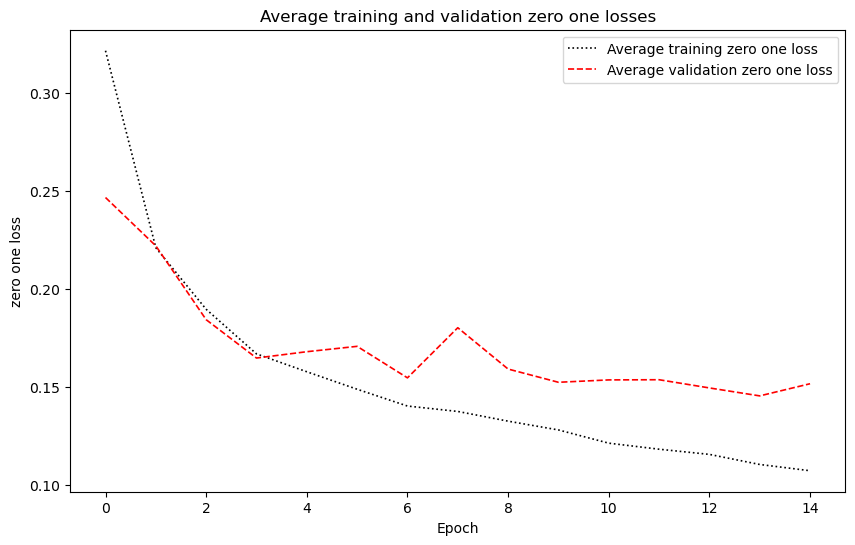

In [49]:
train_zero_one_losses = []
validation_zero_one_losses = []

for history in histories:
    train_zero_one_losses.append(history.history['zero_one_loss'])
    validation_zero_one_losses.append(history.history['val_zero_one_loss'])

matrix = np.array(train_zero_one_losses)
train_mean_loss = np.mean(matrix, axis = 0)

matrix_val = np.array(validation_zero_one_losses)
validation_mean_loss = np.mean(matrix_val, axis = 0)

plt.figure(figsize=(10, 6))

plt.plot(train_mean_loss, label='Average training zero one loss', linestyle=':', linewidth=1.2,color='black')
plt.plot(validation_mean_loss, label='Average validation zero one loss', linestyle='--', linewidth=1.2,color='red')


plt.xlabel('Epoch')
plt.ylabel('zero one loss')
plt.title('Average training and validation zero one losses')
plt.legend()
plt.grid(False)
plt.show()

### The third architecture

In [50]:
# feature extraction
model2 = Sequential()
model2.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu', input_shape=(image_size[0], image_size[1], 3)))
model2.add(MaxPool2D(pool_size=(2, 2)))
model2.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model2.add(MaxPool2D(pool_size=(2, 2)))
# classification
model2.add(Flatten())
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(1, activation='sigmoid'))

In [51]:
model2.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 60, 60, 64)        4864      
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (None, 28, 28, 32)        18464     
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 14, 14, 32)        0         
 ng2D)                                                           
                                                                 
 flatten_13 (Flatten)        (None, 6272)              0         
                                                                 
 dense_19 (Dense)            (None, 256)             

In [52]:
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy', 
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [53]:
history2 = model2.fit(X_train1, y_train1, epochs=15, batch_size=32, verbose=1,  validation_data = (X_validation, y_validation))

Epoch 1/15
119/119 [==============================] - 29s 237ms/step - loss: 0.6116 - accuracy: 0.6606 - precision_13: 0.6734 - recall_13: 0.7324 - val_loss: 0.5511 - val_accuracy: 0.7233 - val_precision_13: 0.6711 - val_recall_13: 0.9254
Epoch 2/15
119/119 [==============================] - 24s 203ms/step - loss: 0.4959 - accuracy: 0.7686 - precision_13: 0.7860 - recall_13: 0.7906 - val_loss: 0.4427 - val_accuracy: 0.8110 - val_precision_13: 0.8856 - val_recall_13: 0.7339
Epoch 3/15
119/119 [==============================] - 26s 216ms/step - loss: 0.4188 - accuracy: 0.8154 - precision_13: 0.8324 - recall_13: 0.8279 - val_loss: 0.3854 - val_accuracy: 0.8437 - val_precision_13: 0.8655 - val_recall_13: 0.8306
Epoch 4/15
119/119 [==============================] - 25s 207ms/step - loss: 0.3878 - accuracy: 0.8328 - precision_13: 0.8488 - recall_13: 0.8434 - val_loss: 0.3838 - val_accuracy: 0.8532 - val_precision_13: 0.8159 - val_recall_13: 0.9294
Epoch 5/15
119/119 [========================

In [54]:
train_loss, train_accuracy, train_precision, train_recall = model2.evaluate(X_train1, y_train1, verbose=0)

In [55]:
print(f'Train Loss: {train_loss:.4f}')
print(f'Train Accuracy: {train_accuracy:.4f}')
print(f'Train Precision: {train_precision:.4f}')
print(f'Train Recall: {train_recall:.4f}')

Train Loss: 0.2091
Train Accuracy: 0.9208
Train Precision: 0.9423
Train Recall: 0.9103


In [56]:
validation_loss, validation_accuracy, validation_precision, validation_recall = model2.evaluate(X_validation, y_validation, verbose=0)

In [57]:
print(f'validation Loss: {validation_loss:.4f}')
print(f'validation Accuracy: {validation_accuracy:.4f}')
print(f'validation Precision: {validation_precision:.4f}')
print(f'validation Recall: {validation_recall:.4f}')

validation Loss: 0.3021
validation Accuracy: 0.8796
validation Precision: 0.8851
validation Recall: 0.8851


*upgrade with Early stopping*

In [58]:
# feature extraction
model3 = Sequential()
model3.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu', input_shape=(image_size[0], image_size[1], 3)))
model3.add(MaxPool2D(pool_size=(2, 2)))
model3.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model3.add(MaxPool2D(pool_size=(2, 2)))
# classification
model3.add(Flatten())
model3.add(Dense(256, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(1, activation='sigmoid'))

In [59]:
early_stopping = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

In [60]:
model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [61]:
history3 = model3.fit(X_train, y_train, epochs=15, batch_size=32, verbose=1,
                      validation_data = (X_validation, y_validation), callbacks=[early_stopping])

Epoch 1/15
148/148 [==============================] - 34s 219ms/step - loss: 0.5741 - accuracy: 0.7004 - precision_14: 0.7198 - recall_14: 0.7300 - val_loss: 0.4681 - val_accuracy: 0.8015 - val_precision_14: 0.8775 - val_recall_14: 0.7218
Epoch 2/15
148/148 [==============================] - 30s 200ms/step - loss: 0.4437 - accuracy: 0.7991 - precision_14: 0.8232 - recall_14: 0.8003 - val_loss: 0.3856 - val_accuracy: 0.8469 - val_precision_14: 0.8758 - val_recall_14: 0.8246
Epoch 3/15
148/148 [==============================] - 32s 215ms/step - loss: 0.4037 - accuracy: 0.8208 - precision_14: 0.8393 - recall_14: 0.8269 - val_loss: 0.3510 - val_accuracy: 0.8680 - val_precision_14: 0.8673 - val_recall_14: 0.8831
Epoch 4/15
148/148 [==============================] - 33s 221ms/step - loss: 0.3606 - accuracy: 0.8468 - precision_14: 0.8519 - recall_14: 0.8675 - val_loss: 0.3516 - val_accuracy: 0.8617 - val_precision_14: 0.8174 - val_recall_14: 0.9476
Epoch 5/15
148/148 [========================

In [62]:
train_loss, train_accuracy, train_precision, train_recall = model3.evaluate(X_train1, y_train1, verbose=0)

In [63]:
print(f'Train Loss: {train_loss:.4f}')
print(f'Train Accuracy: {train_accuracy:.4f}')
print(f'Train Precision: {train_precision:.4f}')
print(f'Train Recall: {train_recall:.4f}')

Train Loss: 0.2064
Train Accuracy: 0.9205
Train Precision: 0.9060
Train Recall: 0.9530


In [64]:
validation_loss, validation_accuracy, validation_precision, validation_recall = model3.evaluate(X_validation, y_validation, verbose=0)

In [65]:
print(f'validation Loss: {validation_loss:.4f}')
print(f'validation Accuracy: {validation_accuracy:.4f}')
print(f'validation Precision: {validation_precision:.4f}')
print(f'validation Recall: {validation_recall:.4f}')

validation Loss: 0.2073
validation Accuracy: 0.9219
validation Precision: 0.8893
validation Recall: 0.9718


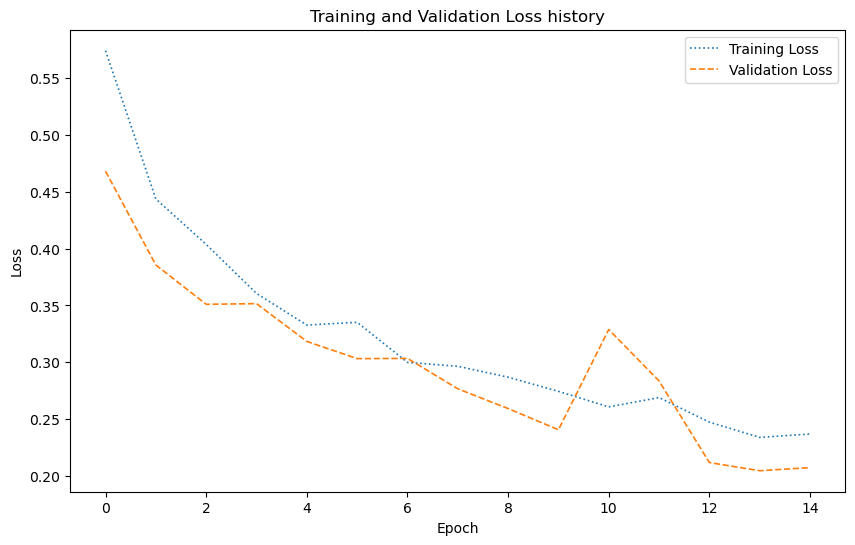

In [66]:
train_loss_history = history3.history['loss']
validation_loss_history = history3.history['val_loss']


plt.figure(figsize=(10, 6))

plt.plot(train_loss_history, label='Training Loss', linestyle=':', linewidth=1.2)
plt.plot(validation_loss_history, label='Validation Loss', linestyle='--', linewidth=1.2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss history')
plt.legend()
plt.grid(False)
plt.show()

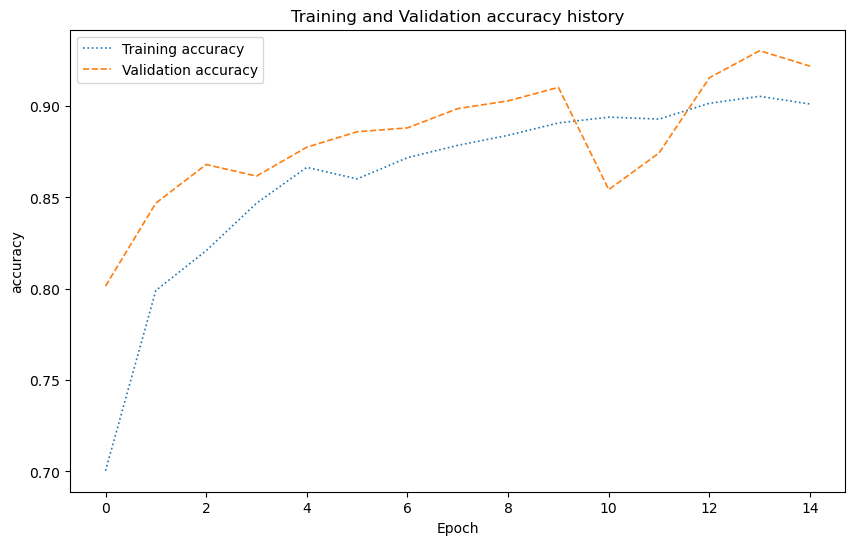

In [67]:
train_accuracy_history = history3.history['accuracy']
validation_accuracy_history = history3.history['val_accuracy']


plt.figure(figsize=(10, 6))

plt.plot(train_accuracy_history, label='Training accuracy', linestyle=':', linewidth=1.2)
plt.plot(validation_accuracy_history, label='Validation accuracy', linestyle='--', linewidth=1.2)
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.title('Training and Validation accuracy history')
plt.legend()
plt.grid(False)
plt.show()

#### 5-fold cross-validation

In [68]:
def model(image_size):
    model3 = Sequential()
    model3.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu', input_shape=(image_size[0], image_size[1], 3)))
    model3.add(MaxPool2D(pool_size=(2, 2)))
    model3.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model3.add(MaxPool2D(pool_size=(2, 2)))
    model3.add(Flatten())
    model3.add(Dense(256, activation='relu'))
    model3.add(Dropout(0.5))
    model3.add(Dense(1, activation='sigmoid'))
    return model

In [69]:
histories = []

for fold, (train_indices, val_indices) in enumerate(kfold.split(X_train, y_train)):
    print(f"Training on Fold {fold+1}...")
    X_train_fold = X_train[train_indices]
    y_train_fold = y_train[train_indices]
    X_val_fold = X_train[val_indices]
    y_val_fold = y_train[val_indices]


    model = create_model(image_size)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), zero_one_loss])

    history = model.fit(X_train_fold, y_train_fold, epochs=15, batch_size=32, verbose=1,
                        validation_data= (X_val_fold, y_val_fold))
    histories.append(history)

Training on Fold 1...
Epoch 1/15
119/119 [==============================] - 14s 110ms/step - loss: 0.6097 - accuracy: 0.6590 - precision_15: 0.6681 - recall_15: 0.7338 - zero_one_loss: 0.3408 - val_loss: 0.5207 - val_accuracy: 0.7592 - val_precision_15: 0.8213 - val_recall_15: 0.7090 - val_zero_one_loss: 0.2389
Epoch 2/15
119/119 [==============================] - 13s 111ms/step - loss: 0.4963 - accuracy: 0.7665 - precision_15: 0.7909 - recall_15: 0.7723 - zero_one_loss: 0.2345 - val_loss: 0.4634 - val_accuracy: 0.7930 - val_precision_15: 0.7948 - val_recall_15: 0.8320 - val_zero_one_loss: 0.2056
Epoch 3/15
119/119 [==============================] - 13s 112ms/step - loss: 0.4495 - accuracy: 0.8016 - precision_15: 0.8246 - recall_15: 0.8041 - zero_one_loss: 0.1989 - val_loss: 0.4263 - val_accuracy: 0.8279 - val_precision_15: 0.8569 - val_recall_15: 0.8184 - val_zero_one_loss: 0.1705
Epoch 4/15
119/119 [==============================] - 13s 107ms/step - loss: 0.4090 - accuracy: 0.8236 - 

Epoch 14/15
119/119 [==============================] - 14s 120ms/step - loss: 0.2770 - accuracy: 0.8867 - precision_16: 0.8878 - recall_16: 0.9047 - zero_one_loss: 0.1132 - val_loss: 0.2979 - val_accuracy: 0.8743 - val_precision_16: 0.8786 - val_recall_16: 0.8906 - val_zero_one_loss: 0.1268
Epoch 15/15
119/119 [==============================] - 12s 105ms/step - loss: 0.2769 - accuracy: 0.8912 - precision_16: 0.8925 - recall_16: 0.9082 - zero_one_loss: 0.1093 - val_loss: 0.3026 - val_accuracy: 0.8807 - val_precision_16: 0.8582 - val_recall_16: 0.9336 - val_zero_one_loss: 0.1206
Training on Fold 3...
Epoch 1/15
119/119 [==============================] - 14s 107ms/step - loss: 0.6036 - accuracy: 0.6978 - precision_17: 0.7004 - recall_17: 0.7709 - zero_one_loss: 0.3022 - val_loss: 0.5069 - val_accuracy: 0.7804 - val_precision_17: 0.8602 - val_recall_17: 0.7090 - val_zero_one_loss: 0.2195
Epoch 2/15
119/119 [==============================] - 12s 104ms/step - loss: 0.4921 - accuracy: 0.7633 

Epoch 12/15
119/119 [==============================] - 13s 110ms/step - loss: 0.3042 - accuracy: 0.8738 - precision_18: 0.8788 - recall_18: 0.8891 - zero_one_loss: 0.1255 - val_loss: 0.3537 - val_accuracy: 0.8478 - val_precision_18: 0.8262 - val_recall_18: 0.9102 - val_zero_one_loss: 0.1524
Epoch 13/15
119/119 [==============================] - 14s 115ms/step - loss: 0.2940 - accuracy: 0.8775 - precision_18: 0.8837 - recall_18: 0.8906 - zero_one_loss: 0.1224 - val_loss: 0.3572 - val_accuracy: 0.8541 - val_precision_18: 0.9013 - val_recall_18: 0.8203 - val_zero_one_loss: 0.1454
Epoch 14/15
119/119 [==============================] - 14s 116ms/step - loss: 0.2986 - accuracy: 0.8693 - precision_18: 0.8767 - recall_18: 0.8823 - zero_one_loss: 0.1305 - val_loss: 0.3484 - val_accuracy: 0.8499 - val_precision_18: 0.8280 - val_recall_18: 0.9121 - val_zero_one_loss: 0.1503
Epoch 15/15
119/119 [==============================] - 13s 109ms/step - loss: 0.2883 - accuracy: 0.8814 - precision_18: 0.88

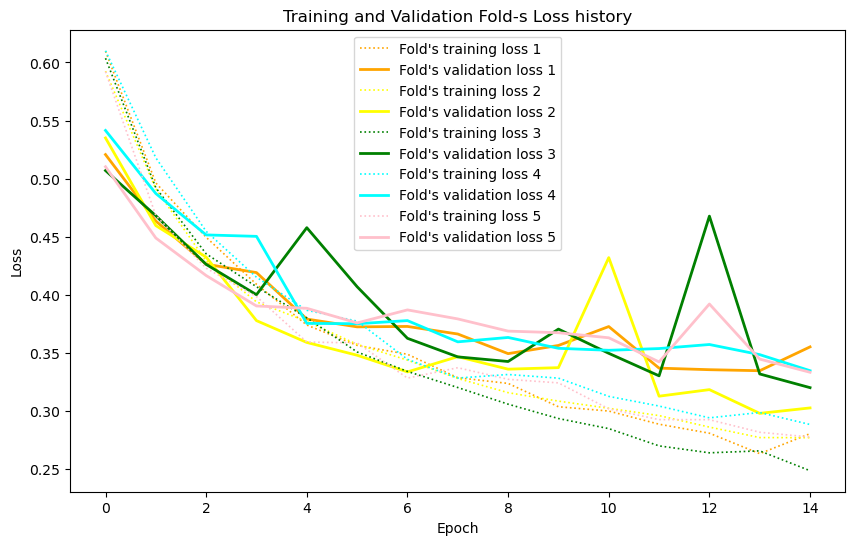

In [70]:
train_accuracies = []
validation_accuracies = []
colors = ['orange', 'yellow', 'green', 'cyan', 'pink']
i = 1
plt.figure(figsize=(10, 6))

for (history, color) in zip(histories, colors):
    plt.plot(history.history["loss"], label="Fold's training loss " + str(i) , linestyle=':', linewidth=1.2,color=color)
    plt.plot(history.history["val_loss"], label="Fold's validation loss " + str(i) , linestyle='-', linewidth=2,color=color)
    i += 1

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Fold-s Loss history')
plt.legend()
plt.grid(False)
plt.show()

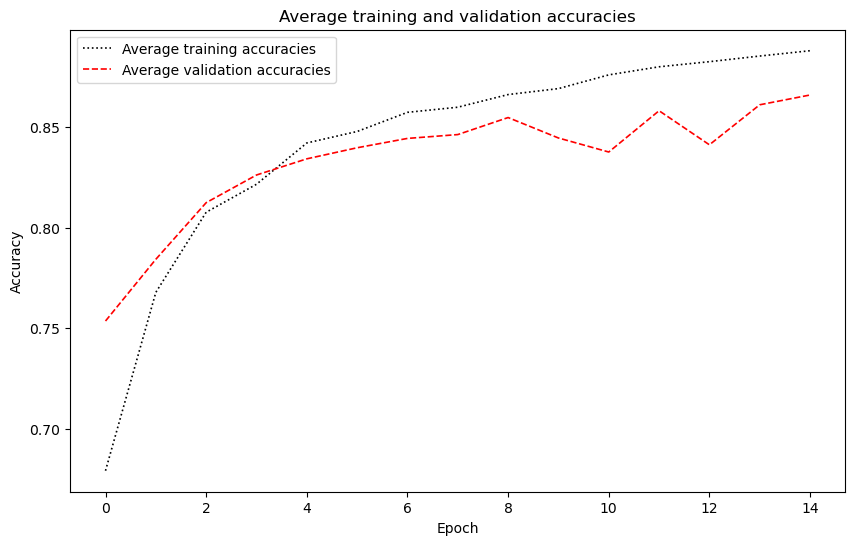

In [71]:
train_accuracies = []
validation_accuracies = []

for history in histories:
    train_accuracies.append(history.history['accuracy'])
    validation_accuracies.append(history.history['val_accuracy'])

matrix = np.array(train_accuracies)
train_mean_accuracies = np.mean(matrix, axis = 0)

matrix_val = np.array(validation_accuracies)
validation_mean_accuracies = np.mean(matrix_val, axis = 0)

plt.figure(figsize=(10, 6))

plt.plot(train_mean_accuracies, label='Average training accuracies', linestyle=':', linewidth=1.2,color='black')
plt.plot(validation_mean_accuracies, label='Average validation accuracies', linestyle='--', linewidth=1.2,color='red')


plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Average training and validation accuracies')
plt.legend()
plt.grid(False)
plt.show()

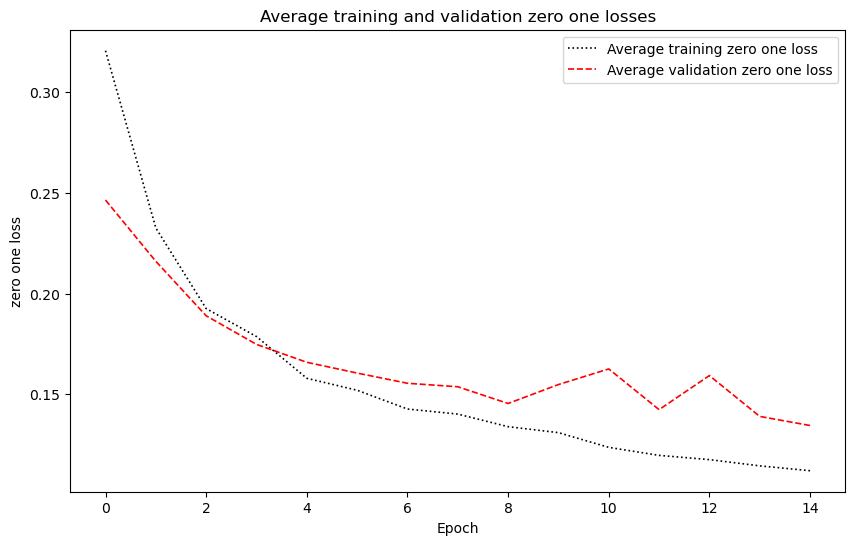

In [72]:
train_zero_one_losses = []
validation_zero_one_losses = []

for history in histories:
    train_zero_one_losses.append(history.history['zero_one_loss'])
    validation_zero_one_losses.append(history.history['val_zero_one_loss'])

matrix = np.array(train_zero_one_losses)
train_mean_loss = np.mean(matrix, axis = 0)

matrix_val = np.array(validation_zero_one_losses)
validation_mean_loss = np.mean(matrix_val, axis = 0)

plt.figure(figsize=(10, 6))

plt.plot(train_mean_loss, label='Average training zero one loss', linestyle=':', linewidth=1.2,color='black')
plt.plot(validation_mean_loss, label='Average validation zero one loss', linestyle='--', linewidth=1.2,color='red')


plt.xlabel('Epoch')
plt.ylabel('zero one loss')
plt.title('Average training and validation zero one losses')
plt.legend()
plt.grid(False)
plt.show()

## Model's tuning

In [73]:
def create_model(hp):
    # feature extraction
    model = Sequential()
    model.add(Conv2D(filters=hp.Int('conv1_filter', min_value=16, max_value=128, step=16),
                     kernel_size=(5, 5), padding='valid', activation='relu', input_shape=(64, 64, 3)))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=hp.Int('conv2_filter', min_value=16, max_value=64, step=16),
                     kernel_size=(3, 3), padding='valid', activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    # classification
    model.add(Flatten())
    model.add(Dense(units=hp.Int('dense_units', min_value=64, max_value=256, step=64), activation='relu'))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.3, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=[zero_one_loss])
    return model

In [74]:
tuner = Hyperband(
    hypermodel=create_model,
    objective='val_loss',
    max_epochs=20,
    directory='/Users/svesh1971/Desktop/UNIMI/ML/',
    project_name='CNN'
)

INFO:tensorflow:Reloading Tuner from /Users/svesh1971/Desktop/UNIMI/ML/CNN/tuner0.json


In [75]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
conv1_filter (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 16, 'sampling': 'linear'}
conv2_filter (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 64, 'sampling': 'linear'}
dropout_rate (Float)
{'default': 0.3, 'conditions': [], 'min_value': 0.3, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}


In [76]:
tuner.search(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2
)

INFO:tensorflow:Oracle triggered exit


In [77]:
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

In [78]:
search_results = tuner.results_summary()
print(search_results)

Results summary
Results in /Users/svesh1971/Desktop/UNIMI/ML/CNN
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0024 summary
Hyperparameters:
conv1_filter: 32
conv2_filter: 64
dense_units: 128
dropout_rate: 0.5
tuner/epochs: 20
tuner/initial_epoch: 7
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0020
Score: 0.21296733617782593

Trial 0005 summary
Hyperparameters:
conv1_filter: 64
conv2_filter: 48
dense_units: 256
dropout_rate: 0.3
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.24227000772953033

Trial 0012 summary
Hyperparameters:
conv1_filter: 64
conv2_filter: 48
dense_units: 256
dropout_rate: 0.3
tuner/epochs: 7
tuner/initial_epoch: 3
tuner/bracket: 2
tuner/round: 1
tuner/trial_id: 0005
Score: 0.24605953693389893

Trial 0020 summary
Hyperparameters:
conv1_filter: 32
conv2_filter: 64
dense_units: 128
dropout_rate: 0.5
tuner/epochs: 7
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.2826695144176483

Trial 002

## Final model's fitting (on the whole training sample)

In [79]:
best_model = create_model(best_hyperparameters)

In [80]:
best_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                   loss='binary_crossentropy',
                   metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), zero_one_loss])

In [81]:
history_tn = best_model.fit(X_train, y_train, epochs=15, batch_size=32, verbose=1, callbacks=[early_stopping])

Epoch 1/15
148/148 [==============================] - 24s 148ms/step - loss: 0.5954 - accuracy: 0.6795 - precision_20: 0.6917 - recall_20: 0.7347 - zero_one_loss: 0.3205
Epoch 2/15
148/148 [==============================] - 25s 167ms/step - loss: 0.4664 - accuracy: 0.7874 - precision_20: 0.8097 - recall_20: 0.7933 - zero_one_loss: 0.2125
Epoch 3/15
148/148 [==============================] - 20s 136ms/step - loss: 0.4096 - accuracy: 0.8223 - precision_20: 0.8387 - recall_20: 0.8312 - zero_one_loss: 0.1776
Epoch 4/15
148/148 [==============================] - 23s 152ms/step - loss: 0.3745 - accuracy: 0.8415 - precision_20: 0.8543 - recall_20: 0.8523 - zero_one_loss: 0.1584
Epoch 5/15
148/148 [==============================] - 20s 133ms/step - loss: 0.3524 - accuracy: 0.8521 - precision_20: 0.8593 - recall_20: 0.8687 - zero_one_loss: 0.1479
Epoch 6/15
148/148 [==============================] - 23s 152ms/step - loss: 0.3410 - accuracy: 0.8618 - precision_20: 0.8699 - recall_20: 0.8753 - ze

In [82]:
best_model.evaluate(X_train, y_train, verbose=0)

[0.22739997506141663,
 0.9051341414451599,
 0.8670842051506042,
 0.9738178849220276,
 0.09491495788097382]

## Prediction

In [83]:
test_results = best_model.evaluate(X_test, y_test)
print("Test Loss:", test_results[0])
print("Test Accuracy:", test_results[1])
print("Test Precision:", test_results[2])
print("Test Recall:", test_results[3])
print("Test Zero-one loss:", test_results[4])

37/37 [==============================] - 1s 34ms/step - loss: 0.3049 - accuracy: 0.8733 - precision_20: 0.8480 - recall_20: 0.9328 - zero_one_loss: 0.1267
Test Loss: 0.3048742711544037
Test Accuracy: 0.8733108043670654
Test Precision: 0.8480113744735718
Test Recall: 0.932812511920929
Test Zero-one loss: 0.12668919563293457


In [84]:
from sklearn.metrics import classification_report
y_pred = best_model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)
report = classification_report(y_test, y_pred)

print(report)

37/37 [==============================] - 1s 32ms/step
              precision    recall  f1-score   support

           0       0.91      0.80      0.85       544
           1       0.85      0.93      0.89       640

    accuracy                           0.87      1184
   macro avg       0.88      0.87      0.87      1184
weighted avg       0.88      0.87      0.87      1184



## ✨ additional tuning✨

In [85]:
import optuna

In [86]:
from sklearn.model_selection import train_test_split


X_train_subsample, X_validation, y_train_subsample, y_validation = train_test_split(X_train, y_train,
                                                                                    test_size=0.25,
                                                                                    random_state=42,
                                                                                    stratify=y_train)

print("X_train_subsample shape:", X_train_subsample.shape)
print("y_train_subsample shape:", y_train_subsample.shape)
print("X_validation shape:", X_validation.shape)
print("y_validation shape:", y_validation.shape)


X_train_subsample shape: (3549, 64, 64, 3)
y_train_subsample shape: (3549,)
X_validation shape: (1184, 64, 64, 3)
y_validation shape: (1184,)


In [87]:
def create_model(params):
    model = Sequential()

    model.add(
        Conv2D(filters=params['filters1'],
               kernel_size=(params['kernel_size1'], params['kernel_size1']),
               activation=params['activation'],
               input_shape=(64, 64, 3)))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(
        Conv2D(filters=params['filters2'],
               kernel_size=(params['kernel_size2'], params['kernel_size2']),
               activation=params['activation'],
               input_shape=(64, 64, 3)))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Flatten())

    if params['final_mlp_hidden_neurons'] > 0:
        model.add(Dense(params['final_mlp_hidden_neurons'], activation=params['activation']))

    model.add(Dropout(params['dropout']))

    model.add(Dense(1, activation='sigmoid'))
    return model

In [88]:
def objective(trial):
    params = {
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh']),
        'filters1': trial.suggest_int('filters1', 16, 128, 16),
        'filters2': trial.suggest_int('filters2', 16, 128, 16),
        'kernel_size1': trial.suggest_int('kernel_size1', 3, 5, 2),
        'kernel_size2': trial.suggest_int('kernel_size21', 3, 5, 2),
        'final_mlp_hidden_neurons': trial.suggest_int('final_mlp_hidden_neurons', 0, 128, 16),
        'dropout': trial.suggest_float('dropout_rate', 0.0, 0.5),
    }
    model = create_model(params)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='binary_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(X_train_subsample, y_train_subsample, epochs=20, batch_size=32, verbose=1,
                      validation_data = (X_validation, y_validation), callbacks=[early_stopping])
    final_loss = history.history['val_loss'][-1]
    print(history.history['val_loss'])
    return final_loss

In [89]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

[I 2023-08-01 11:38:53,747] A new study created in memory with name: no-name-58e25ed1-c8d8-4e53-9bef-159f73135dff


Epoch 1/20
111/111 [==============================] - 83s 740ms/step - loss: 0.6052 - accuracy: 0.6689 - val_loss: 0.5404 - val_accuracy: 0.7238
Epoch 2/20
111/111 [==============================] - 84s 762ms/step - loss: 0.5066 - accuracy: 0.7585 - val_loss: 0.4396 - val_accuracy: 0.8193
Epoch 3/20
111/111 [==============================] - 84s 759ms/step - loss: 0.4319 - accuracy: 0.8061 - val_loss: 0.3953 - val_accuracy: 0.8421
Epoch 4/20
111/111 [==============================] - 87s 781ms/step - loss: 0.3733 - accuracy: 0.8431 - val_loss: 0.3388 - val_accuracy: 0.8632
Epoch 5/20
111/111 [==============================] - 84s 756ms/step - loss: 0.3496 - accuracy: 0.8509 - val_loss: 0.3138 - val_accuracy: 0.8784
Epoch 6/20
111/111 [==============================] - 86s 774ms/step - loss: 0.3232 - accuracy: 0.8704 - val_loss: 0.3152 - val_accuracy: 0.8725
Epoch 7/20
111/111 [==============================] - 86s 777ms/step - loss: 0.3060 - accuracy: 0.8771 - val_loss: 0.3086 - val_ac

[I 2023-08-01 12:07:12,721] Trial 0 finished with value: 0.27788782119750977 and parameters: {'activation': 'relu', 'filters1': 128, 'filters2': 96, 'kernel_size1': 5, 'kernel_size21': 5, 'final_mlp_hidden_neurons': 80, 'dropout_rate': 0.32470547615121}. Best is trial 0 with value: 0.27788782119750977.


[0.5404062271118164, 0.43960875272750854, 0.3952608108520508, 0.3388291299343109, 0.31379953026771545, 0.31521615386009216, 0.3085556924343109, 0.29208460450172424, 0.2918718159198761, 0.3086707293987274, 0.2819103002548218, 0.27809736132621765, 0.33527493476867676, 0.27149513363838196, 0.3757855296134949, 0.26741981506347656, 0.25831425189971924, 0.2855014204978943, 0.2815193235874176, 0.27788782119750977]
Epoch 1/20
111/111 [==============================] - 16s 136ms/step - loss: 0.5736 - accuracy: 0.6985 - val_loss: 0.4745 - val_accuracy: 0.7736
Epoch 2/20
111/111 [==============================] - 13s 118ms/step - loss: 0.4614 - accuracy: 0.7921 - val_loss: 0.4929 - val_accuracy: 0.7576
Epoch 3/20
111/111 [==============================] - 13s 118ms/step - loss: 0.4329 - accuracy: 0.8095 - val_loss: 0.4090 - val_accuracy: 0.8252
Epoch 4/20
111/111 [==============================] - 13s 114ms/step - loss: 0.3914 - accuracy: 0.8388 - val_loss: 0.3894 - val_accuracy: 0.8429
Epoch 5/2

[I 2023-08-01 12:11:48,854] Trial 1 finished with value: 0.35548803210258484 and parameters: {'activation': 'tanh', 'filters1': 16, 'filters2': 48, 'kernel_size1': 5, 'kernel_size21': 5, 'final_mlp_hidden_neurons': 96, 'dropout_rate': 0.18498898953826048}. Best is trial 0 with value: 0.27788782119750977.


[0.4745364189147949, 0.49289166927337646, 0.40903523564338684, 0.3893898129463196, 0.39811158180236816, 0.38673219084739685, 0.36541351675987244, 0.3828181326389313, 0.3677293360233307, 0.39929360151290894, 0.37201374769210815, 0.3786749541759491, 0.36945563554763794, 0.3518114686012268, 0.3606499135494232, 0.35551518201828003, 0.381471186876297, 0.35893282294273376, 0.3710092604160309, 0.35548803210258484]
Epoch 1/20
111/111 [==============================] - 62s 549ms/step - loss: 0.5740 - accuracy: 0.6954 - val_loss: 0.4567 - val_accuracy: 0.7939
Epoch 2/20
111/111 [==============================] - 63s 569ms/step - loss: 0.4409 - accuracy: 0.8033 - val_loss: 0.3657 - val_accuracy: 0.8471
Epoch 3/20
111/111 [==============================] - 64s 580ms/step - loss: 0.3971 - accuracy: 0.8315 - val_loss: 0.3469 - val_accuracy: 0.8573
Epoch 4/20
111/111 [==============================] - 59s 536ms/step - loss: 0.3579 - accuracy: 0.8436 - val_loss: 0.3657 - val_accuracy: 0.8421
Epoch 5/2

[I 2023-08-01 12:32:18,912] Trial 2 finished with value: 0.2594141364097595 and parameters: {'activation': 'relu', 'filters1': 80, 'filters2': 112, 'kernel_size1': 3, 'kernel_size21': 5, 'final_mlp_hidden_neurons': 128, 'dropout_rate': 0.3260523508151594}. Best is trial 2 with value: 0.2594141364097595.


[0.45665425062179565, 0.3657352328300476, 0.3468705415725708, 0.365741491317749, 0.34116867184638977, 0.33789822459220886, 0.2890591025352478, 0.2827152907848358, 0.2808208465576172, 0.3161829710006714, 0.2728288173675537, 0.3399851322174072, 0.26996660232543945, 0.25529372692108154, 0.2600615620613098, 0.2507515847682953, 0.2731013894081116, 0.26780349016189575, 0.25221508741378784, 0.2594141364097595]
Epoch 1/20
111/111 [==============================] - 14s 120ms/step - loss: 0.6051 - accuracy: 0.6748 - val_loss: 0.5122 - val_accuracy: 0.7584
Epoch 2/20
111/111 [==============================] - 9s 85ms/step - loss: 0.4910 - accuracy: 0.7712 - val_loss: 0.4487 - val_accuracy: 0.8032
Epoch 3/20
111/111 [==============================] - 10s 92ms/step - loss: 0.4459 - accuracy: 0.7985 - val_loss: 0.4041 - val_accuracy: 0.8209
Epoch 4/20
111/111 [==============================] - 13s 117ms/step - loss: 0.4069 - accuracy: 0.8228 - val_loss: 0.3964 - val_accuracy: 0.8277
Epoch 5/20
111/1

[I 2023-08-01 12:35:49,044] Trial 3 finished with value: 0.32537737488746643 and parameters: {'activation': 'relu', 'filters1': 16, 'filters2': 32, 'kernel_size1': 5, 'kernel_size21': 3, 'final_mlp_hidden_neurons': 96, 'dropout_rate': 0.31887579641725955}. Best is trial 2 with value: 0.2594141364097595.


[0.5122154951095581, 0.4487382471561432, 0.4041307270526886, 0.3964173197746277, 0.40627995133399963, 0.3756682872772217, 0.3667445182800293, 0.3505023121833801, 0.3351188898086548, 0.3317532241344452, 0.32635924220085144, 0.3387131690979004, 0.3196015954017639, 0.3170381486415863, 0.32144397497177124, 0.31372714042663574, 0.31411415338516235, 0.3236808478832245, 0.30775880813598633, 0.32537737488746643]
Epoch 1/20
111/111 [==============================] - 18s 155ms/step - loss: 0.5907 - accuracy: 0.6878 - val_loss: 0.4687 - val_accuracy: 0.7897
Epoch 2/20
111/111 [==============================] - 20s 183ms/step - loss: 0.4712 - accuracy: 0.7864 - val_loss: 0.4362 - val_accuracy: 0.8091
Epoch 3/20
111/111 [==============================] - 18s 158ms/step - loss: 0.4387 - accuracy: 0.8104 - val_loss: 0.4443 - val_accuracy: 0.7939
Epoch 4/20
111/111 [==============================] - 20s 178ms/step - loss: 0.4134 - accuracy: 0.8233 - val_loss: 0.4236 - val_accuracy: 0.8193
Epoch 5/20
1

[I 2023-08-01 12:41:54,347] Trial 4 finished with value: 0.34720465540885925 and parameters: {'activation': 'tanh', 'filters1': 32, 'filters2': 96, 'kernel_size1': 5, 'kernel_size21': 3, 'final_mlp_hidden_neurons': 64, 'dropout_rate': 0.464535105100323}. Best is trial 2 with value: 0.2594141364097595.


[0.4687262773513794, 0.4362378418445587, 0.44433701038360596, 0.4235678017139435, 0.41023486852645874, 0.413656622171402, 0.3906933665275574, 0.37188494205474854, 0.3724765181541443, 0.39023515582084656, 0.37096089124679565, 0.4101667106151581, 0.3523145914077759, 0.4219268262386322, 0.35857611894607544, 0.35356324911117554, 0.34872281551361084, 0.36138710379600525, 0.35777807235717773, 0.34720465540885925]
Epoch 1/20
111/111 [==============================] - 26s 212ms/step - loss: 0.6083 - accuracy: 0.6588 - val_loss: 0.5183 - val_accuracy: 0.7669
Epoch 2/20
111/111 [==============================] - 27s 240ms/step - loss: 0.5015 - accuracy: 0.7715 - val_loss: 0.4732 - val_accuracy: 0.7796
Epoch 3/20
111/111 [==============================] - 24s 216ms/step - loss: 0.4583 - accuracy: 0.7994 - val_loss: 0.4787 - val_accuracy: 0.7804
Epoch 4/20
111/111 [==============================] - 26s 234ms/step - loss: 0.4410 - accuracy: 0.8033 - val_loss: 0.4247 - val_accuracy: 0.8159
Epoch 5/2

[I 2023-08-01 12:50:18,045] Trial 5 finished with value: 0.3376649022102356 and parameters: {'activation': 'tanh', 'filters1': 64, 'filters2': 64, 'kernel_size1': 5, 'kernel_size21': 3, 'final_mlp_hidden_neurons': 16, 'dropout_rate': 0.10430486150397633}. Best is trial 2 with value: 0.2594141364097595.


[0.5183103680610657, 0.4731503129005432, 0.47865381836891174, 0.42465272545814514, 0.3930095136165619, 0.3875478208065033, 0.3925293982028961, 0.36775562167167664, 0.3654816746711731, 0.3612980842590332, 0.37057286500930786, 0.3556104302406311, 0.3495364189147949, 0.3510226309299469, 0.34894242882728577, 0.3538475036621094, 0.37946954369544983, 0.40319356322288513, 0.3405115306377411, 0.3376649022102356]
Epoch 1/20
111/111 [==============================] - 22s 188ms/step - loss: 0.5918 - accuracy: 0.6808 - val_loss: 0.5069 - val_accuracy: 0.7703
Epoch 2/20
111/111 [==============================] - 23s 204ms/step - loss: 0.4580 - accuracy: 0.7921 - val_loss: 0.4145 - val_accuracy: 0.8218
Epoch 3/20
111/111 [==============================] - 20s 177ms/step - loss: 0.3999 - accuracy: 0.8287 - val_loss: 0.3668 - val_accuracy: 0.8539
Epoch 4/20
111/111 [==============================] - 20s 177ms/step - loss: 0.3558 - accuracy: 0.8549 - val_loss: 0.3536 - val_accuracy: 0.8488
Epoch 5/20
1

[I 2023-08-01 12:57:17,273] Trial 6 finished with value: 0.26205146312713623 and parameters: {'activation': 'relu', 'filters1': 48, 'filters2': 80, 'kernel_size1': 3, 'kernel_size21': 3, 'final_mlp_hidden_neurons': 128, 'dropout_rate': 0.26236630181926945}. Best is trial 2 with value: 0.2594141364097595.


[0.5069200396537781, 0.41449475288391113, 0.36680927872657776, 0.35362735390663147, 0.3382143974304199, 0.31623318791389465, 0.30982527136802673, 0.3033370077610016, 0.2955286502838135, 0.2894879877567291, 0.2964293956756592, 0.2906550467014313, 0.28010377287864685, 0.28064727783203125, 0.27905067801475525, 0.2800646126270294, 0.27102208137512207, 0.26656442880630493, 0.2699117362499237, 0.26205146312713623]
Epoch 1/20
111/111 [==============================] - 35s 307ms/step - loss: 0.5838 - accuracy: 0.6920 - val_loss: 0.4605 - val_accuracy: 0.7922
Epoch 2/20
111/111 [==============================] - 32s 281ms/step - loss: 0.4621 - accuracy: 0.7878 - val_loss: 0.4006 - val_accuracy: 0.8277
Epoch 3/20
111/111 [==============================] - 33s 294ms/step - loss: 0.3898 - accuracy: 0.8281 - val_loss: 0.3843 - val_accuracy: 0.8319
Epoch 4/20
111/111 [==============================] - 34s 306ms/step - loss: 0.3582 - accuracy: 0.8484 - val_loss: 0.3462 - val_accuracy: 0.8497
Epoch 5/

[I 2023-08-01 13:08:15,496] Trial 7 finished with value: 0.31001347303390503 and parameters: {'activation': 'relu', 'filters1': 64, 'filters2': 112, 'kernel_size1': 5, 'kernel_size21': 3, 'final_mlp_hidden_neurons': 128, 'dropout_rate': 0.003444022855682183}. Best is trial 2 with value: 0.2594141364097595.


[0.460456907749176, 0.4006049931049347, 0.38427460193634033, 0.3461841642856598, 0.35995858907699585, 0.3230721354484558, 0.3196518123149872, 0.31891098618507385, 0.4721749722957611, 0.3075747787952423, 0.3147999346256256, 0.3097153306007385, 0.32586702704429626, 0.3017476797103882, 0.30334925651550293, 0.3136022686958313, 0.3300405442714691, 0.29685887694358826, 0.3327980637550354, 0.31001347303390503]
Epoch 1/20
111/111 [==============================] - 36s 312ms/step - loss: 0.5737 - accuracy: 0.7027 - val_loss: 0.4938 - val_accuracy: 0.7728
Epoch 2/20
111/111 [==============================] - 34s 310ms/step - loss: 0.4867 - accuracy: 0.7698 - val_loss: 0.4478 - val_accuracy: 0.7948
Epoch 3/20
111/111 [==============================] - 32s 290ms/step - loss: 0.4481 - accuracy: 0.8014 - val_loss: 0.4391 - val_accuracy: 0.7905
Epoch 4/20
111/111 [==============================] - 35s 316ms/step - loss: 0.4260 - accuracy: 0.8168 - val_loss: 0.4148 - val_accuracy: 0.8066
Epoch 5/20
11

[I 2023-08-01 13:20:11,292] Trial 8 finished with value: 0.35222530364990234 and parameters: {'activation': 'tanh', 'filters1': 64, 'filters2': 48, 'kernel_size1': 5, 'kernel_size21': 5, 'final_mlp_hidden_neurons': 16, 'dropout_rate': 0.2022845990481536}. Best is trial 2 with value: 0.2594141364097595.


[0.4937512278556824, 0.44776132702827454, 0.4391312599182129, 0.4148223102092743, 0.410845547914505, 0.3821484446525574, 0.3877345025539398, 0.3916418254375458, 0.3689626157283783, 0.3746556341648102, 0.37090811133384705, 0.36189064383506775, 0.3621056377887726, 0.4354546070098877, 0.3546549379825592, 0.3542972505092621, 0.3470207750797272, 0.3793433606624603, 0.3510761559009552, 0.35222530364990234]
Epoch 1/20
111/111 [==============================] - 30s 262ms/step - loss: 0.5711 - accuracy: 0.7053 - val_loss: 0.4803 - val_accuracy: 0.7821
Epoch 2/20
111/111 [==============================] - 26s 237ms/step - loss: 0.4837 - accuracy: 0.7735 - val_loss: 0.4588 - val_accuracy: 0.7956
Epoch 3/20
111/111 [==============================] - 29s 261ms/step - loss: 0.4424 - accuracy: 0.8163 - val_loss: 0.4163 - val_accuracy: 0.8150
Epoch 4/20
111/111 [==============================] - 29s 263ms/step - loss: 0.4142 - accuracy: 0.8261 - val_loss: 0.3896 - val_accuracy: 0.8336
Epoch 5/20
111/1

[I 2023-08-01 13:29:29,068] Trial 9 finished with value: 0.34959322214126587 and parameters: {'activation': 'tanh', 'filters1': 32, 'filters2': 112, 'kernel_size1': 5, 'kernel_size21': 5, 'final_mlp_hidden_neurons': 16, 'dropout_rate': 0.37304914074551876}. Best is trial 2 with value: 0.2594141364097595.


[0.4803191125392914, 0.4588457942008972, 0.41628557443618774, 0.38962000608444214, 0.4473399519920349, 0.3775094449520111, 0.3628275990486145, 0.3780258297920227, 0.35791853070259094, 0.3491077721118927, 0.39590150117874146, 0.35850271582603455, 0.35087308287620544, 0.34787657856941223, 0.3509049117565155, 0.3444201350212097, 0.35071516036987305, 0.352443665266037, 0.34346333146095276, 0.34959322214126587]
Epoch 1/20
111/111 [==============================] - 91s 813ms/step - loss: 0.6190 - accuracy: 0.6424 - val_loss: 0.4950 - val_accuracy: 0.7736
Epoch 2/20
111/111 [==============================] - 86s 777ms/step - loss: 0.4809 - accuracy: 0.7816 - val_loss: 0.4074 - val_accuracy: 0.8395
Epoch 3/20
111/111 [==============================] - 86s 772ms/step - loss: 0.4184 - accuracy: 0.8273 - val_loss: 0.4339 - val_accuracy: 0.7981
Epoch 4/20
111/111 [==============================] - 86s 778ms/step - loss: 0.3828 - accuracy: 0.8439 - val_loss: 0.3485 - val_accuracy: 0.8530
Epoch 5/20

[I 2023-08-01 13:59:03,760] Trial 10 finished with value: 0.24558833241462708 and parameters: {'activation': 'relu', 'filters1': 112, 'filters2': 128, 'kernel_size1': 3, 'kernel_size21': 5, 'final_mlp_hidden_neurons': 48, 'dropout_rate': 0.47335033270818977}. Best is trial 10 with value: 0.24558833241462708.


[0.4949590265750885, 0.4073743522167206, 0.43392691016197205, 0.3485246002674103, 0.31176653504371643, 0.3167927861213684, 0.28343987464904785, 0.35864686965942383, 0.28725093603134155, 0.26356643438339233, 0.2582341134548187, 0.2613546848297119, 0.25625962018966675, 0.25705599784851074, 0.2567238509654999, 0.24335868656635284, 0.24407486617565155, 0.24995103478431702, 0.2529512345790863, 0.24558833241462708]
Epoch 1/20
111/111 [==============================] - 86s 765ms/step - loss: 0.6236 - accuracy: 0.6512 - val_loss: 0.5245 - val_accuracy: 0.7424
Epoch 2/20
111/111 [==============================] - 86s 779ms/step - loss: 0.5420 - accuracy: 0.7427 - val_loss: 0.4926 - val_accuracy: 0.7812
Epoch 3/20
111/111 [==============================] - 89s 801ms/step - loss: 0.4765 - accuracy: 0.7808 - val_loss: 0.4191 - val_accuracy: 0.7981
Epoch 4/20
111/111 [==============================] - 86s 778ms/step - loss: 0.4217 - accuracy: 0.8160 - val_loss: 0.3715 - val_accuracy: 0.8480
Epoch 5

[I 2023-08-01 14:28:13,387] Trial 11 finished with value: 0.24976737797260284 and parameters: {'activation': 'relu', 'filters1': 112, 'filters2': 128, 'kernel_size1': 3, 'kernel_size21': 5, 'final_mlp_hidden_neurons': 48, 'dropout_rate': 0.4561296855352711}. Best is trial 10 with value: 0.24558833241462708.


[0.5245147943496704, 0.4925900995731354, 0.41910022497177124, 0.3715337812900543, 0.34611091017723083, 0.3444003462791443, 0.3302668333053589, 0.2950802445411682, 0.3195716440677643, 0.28915339708328247, 0.2764490246772766, 0.2703195810317993, 0.2680095136165619, 0.25917401909828186, 0.2660374939441681, 0.2615029811859131, 0.25661444664001465, 0.2846592664718628, 0.3010942339897156, 0.24976737797260284]
Epoch 1/20
111/111 [==============================] - 87s 772ms/step - loss: 0.6203 - accuracy: 0.6520 - val_loss: 0.5378 - val_accuracy: 0.7356
Epoch 2/20
111/111 [==============================] - 87s 781ms/step - loss: 0.4989 - accuracy: 0.7661 - val_loss: 0.4433 - val_accuracy: 0.8083
Epoch 3/20
111/111 [==============================] - 87s 783ms/step - loss: 0.4561 - accuracy: 0.7985 - val_loss: 0.3869 - val_accuracy: 0.8387
Epoch 4/20
111/111 [==============================] - 88s 794ms/step - loss: 0.4200 - accuracy: 0.8191 - val_loss: 0.3598 - val_accuracy: 0.8522
Epoch 5/20
11

[I 2023-08-01 14:57:11,477] Trial 12 finished with value: 0.2453456073999405 and parameters: {'activation': 'relu', 'filters1': 112, 'filters2': 128, 'kernel_size1': 3, 'kernel_size21': 5, 'final_mlp_hidden_neurons': 48, 'dropout_rate': 0.4974614665057987}. Best is trial 12 with value: 0.2453456073999405.


[0.5378367304801941, 0.4432646334171295, 0.3869224190711975, 0.35981279611587524, 0.32847830653190613, 0.30923542380332947, 0.3201868534088135, 0.33171266317367554, 0.2937968373298645, 0.3053394854068756, 0.2789318859577179, 0.2655682861804962, 0.3215794265270233, 0.26917505264282227, 0.25030240416526794, 0.262134850025177, 0.24619030952453613, 0.24239769577980042, 0.2732369601726532, 0.2453456073999405]
Epoch 1/20
111/111 [==============================] - 80s 709ms/step - loss: 0.6381 - accuracy: 0.6348 - val_loss: 0.5296 - val_accuracy: 0.7424
Epoch 2/20
111/111 [==============================] - 77s 694ms/step - loss: 0.5380 - accuracy: 0.7340 - val_loss: 0.4617 - val_accuracy: 0.8209
Epoch 3/20
111/111 [==============================] - 76s 684ms/step - loss: 0.4838 - accuracy: 0.7799 - val_loss: 0.4118 - val_accuracy: 0.8277
Epoch 4/20
111/111 [==============================] - 77s 694ms/step - loss: 0.4310 - accuracy: 0.8211 - val_loss: 0.3628 - val_accuracy: 0.8497
Epoch 5/20
1

[I 2023-08-01 15:38:47,690] Trial 13 finished with value: 0.24644875526428223 and parameters: {'activation': 'relu', 'filters1': 96, 'filters2': 128, 'kernel_size1': 3, 'kernel_size21': 5, 'final_mlp_hidden_neurons': 48, 'dropout_rate': 0.4968357545403952}. Best is trial 12 with value: 0.2453456073999405.


[0.5296130180358887, 0.4616895020008087, 0.41176077723503113, 0.36275166273117065, 0.3527662456035614, 0.33409860730171204, 0.404354065656662, 0.320799320936203, 0.3495705723762512, 0.32751309871673584, 0.29306361079216003, 0.28023722767829895, 0.33410152792930603, 0.272391140460968, 0.27259567379951477, 0.2641241252422333, 0.28476306796073914, 0.2628522217273712, 0.2530011534690857, 0.24644875526428223]
Epoch 1/20
111/111 [==============================] - 63s 556ms/step - loss: 0.6481 - accuracy: 0.6255 - val_loss: 0.5563 - val_accuracy: 0.7525
Epoch 2/20
111/111 [==============================] - 72s 647ms/step - loss: 0.5529 - accuracy: 0.7216 - val_loss: 0.4848 - val_accuracy: 0.7855
Epoch 3/20
111/111 [==============================] - 66s 600ms/step - loss: 0.5025 - accuracy: 0.7712 - val_loss: 0.4717 - val_accuracy: 0.7644
Epoch 4/20
111/111 [==============================] - 72s 648ms/step - loss: 0.4552 - accuracy: 0.7977 - val_loss: 0.3895 - val_accuracy: 0.8387
Epoch 5/20
1

[I 2023-08-01 15:59:04,333] Trial 14 finished with value: 0.2674340009689331 and parameters: {'activation': 'relu', 'filters1': 128, 'filters2': 16, 'kernel_size1': 3, 'kernel_size21': 5, 'final_mlp_hidden_neurons': 48, 'dropout_rate': 0.4248786911499324}. Best is trial 12 with value: 0.2453456073999405.


[0.556282639503479, 0.4848262071609497, 0.47168681025505066, 0.3894801139831543, 0.36839887499809265, 0.4108397364616394, 0.4167926013469696, 0.32619890570640564, 0.3535236120223999, 0.3145880103111267, 0.31315967440605164, 0.2950093746185303, 0.2904042899608612, 0.33239489793777466, 0.27933356165885925, 0.27804192900657654, 0.28319746255874634, 0.2730902135372162, 0.28266310691833496, 0.2674340009689331]
Epoch 1/20
111/111 [==============================] - 100s 889ms/step - loss: 0.6304 - accuracy: 0.6591 - val_loss: 0.5344 - val_accuracy: 0.7399
Epoch 2/20
111/111 [==============================] - 98s 884ms/step - loss: 0.5343 - accuracy: 0.7442 - val_loss: 0.4856 - val_accuracy: 0.7660
Epoch 3/20
111/111 [==============================] - 101s 908ms/step - loss: 0.4570 - accuracy: 0.8002 - val_loss: 0.3984 - val_accuracy: 0.8319
Epoch 4/20
111/111 [==============================] - 98s 886ms/step - loss: 0.4119 - accuracy: 0.8225 - val_loss: 0.3778 - val_accuracy: 0.8446
Epoch 5/2

[I 2023-08-01 17:07:41,817] Trial 15 finished with value: 0.27320969104766846 and parameters: {'activation': 'relu', 'filters1': 96, 'filters2': 128, 'kernel_size1': 3, 'kernel_size21': 5, 'final_mlp_hidden_neurons': 0, 'dropout_rate': 0.41373778819281615}. Best is trial 12 with value: 0.2453456073999405.


[0.5344088077545166, 0.4855600893497467, 0.3984079957008362, 0.37779662013053894, 0.34797680377960205, 0.3982996344566345, 0.3507601022720337, 0.33597254753112793, 0.324084609746933, 0.3220844566822052, 0.30268463492393494, 0.3168332278728485, 0.31051990389823914, 0.29340505599975586, 0.33520233631134033, 0.28008872270584106, 0.2764795124530792, 0.397294282913208, 0.2758868932723999, 0.27320969104766846]
Epoch 1/20
111/111 [==============================] - 88s 777ms/step - loss: 0.6174 - accuracy: 0.6624 - val_loss: 0.5846 - val_accuracy: 0.6841
Epoch 2/20
111/111 [==============================] - 84s 758ms/step - loss: 0.5175 - accuracy: 0.7678 - val_loss: 0.4320 - val_accuracy: 0.8176
Epoch 3/20
111/111 [==============================] - 81s 731ms/step - loss: 0.4552 - accuracy: 0.7960 - val_loss: 0.3824 - val_accuracy: 0.8421
Epoch 4/20
111/111 [==============================] - 75s 678ms/step - loss: 0.3990 - accuracy: 0.8298 - val_loss: 0.4223 - val_accuracy: 0.8100
Epoch 5/20
1

[I 2023-08-01 17:36:10,357] Trial 16 finished with value: 0.2503446638584137 and parameters: {'activation': 'relu', 'filters1': 112, 'filters2': 96, 'kernel_size1': 3, 'kernel_size21': 5, 'final_mlp_hidden_neurons': 32, 'dropout_rate': 0.4978367153386897}. Best is trial 12 with value: 0.2453456073999405.


[0.5846013426780701, 0.4319804608821869, 0.3823818564414978, 0.42228230834007263, 0.3363800048828125, 0.33427292108535767, 0.2986672520637512, 0.32952794432640076, 0.3156086206436157, 0.3642442524433136, 0.29096367955207825, 0.2930329740047455, 0.26352909207344055, 0.2606629431247711, 0.2544178068637848, 0.25064536929130554, 0.269538938999176, 0.2791341543197632, 0.2536584138870239, 0.2503446638584137]
Epoch 1/20
111/111 [==============================] - 71s 629ms/step - loss: 0.6153 - accuracy: 0.6605 - val_loss: 0.5088 - val_accuracy: 0.7483
Epoch 2/20
111/111 [==============================] - 69s 617ms/step - loss: 0.4934 - accuracy: 0.7664 - val_loss: 0.4155 - val_accuracy: 0.8201
Epoch 3/20
111/111 [==============================] - 71s 639ms/step - loss: 0.4172 - accuracy: 0.8208 - val_loss: 0.4357 - val_accuracy: 0.8024
Epoch 4/20
111/111 [==============================] - 72s 645ms/step - loss: 0.3939 - accuracy: 0.8284 - val_loss: 0.3543 - val_accuracy: 0.8480
Epoch 5/20
111

[I 2023-08-01 17:58:48,188] Trial 17 finished with value: 0.28756552934646606 and parameters: {'activation': 'relu', 'filters1': 96, 'filters2': 80, 'kernel_size1': 3, 'kernel_size21': 5, 'final_mlp_hidden_neurons': 64, 'dropout_rate': 0.39879370369595574}. Best is trial 12 with value: 0.2453456073999405.


[0.5088369250297546, 0.41547340154647827, 0.435724675655365, 0.35432517528533936, 0.3301851451396942, 0.32215166091918945, 0.30684614181518555, 0.4013443887233734, 0.3036870062351227, 0.3418557047843933, 0.27251875400543213, 0.2764875888824463, 0.27891743183135986, 0.2859679162502289, 0.256203293800354, 0.26382312178611755, 0.26420414447784424, 0.25078779458999634, 0.30527132749557495, 0.28756552934646606]
Epoch 1/20
111/111 [==============================] - 101s 893ms/step - loss: 0.6023 - accuracy: 0.6653 - val_loss: 0.4772 - val_accuracy: 0.7846
Epoch 2/20
111/111 [==============================] - 97s 878ms/step - loss: 0.4786 - accuracy: 0.7797 - val_loss: 0.4126 - val_accuracy: 0.8345
Epoch 3/20
111/111 [==============================] - 91s 823ms/step - loss: 0.4186 - accuracy: 0.8208 - val_loss: 0.3959 - val_accuracy: 0.8328
Epoch 4/20
111/111 [==============================] - 92s 832ms/step - loss: 0.3791 - accuracy: 0.8411 - val_loss: 0.3503 - val_accuracy: 0.8573
Epoch 5/2

[I 2023-08-01 18:30:45,721] Trial 18 finished with value: 0.2339727282524109 and parameters: {'activation': 'relu', 'filters1': 112, 'filters2': 128, 'kernel_size1': 3, 'kernel_size21': 5, 'final_mlp_hidden_neurons': 80, 'dropout_rate': 0.4395770047305186}. Best is trial 18 with value: 0.2339727282524109.


[0.47716954350471497, 0.4125828444957733, 0.3959375023841858, 0.35034018754959106, 0.30958348512649536, 0.33684685826301575, 0.3948080539703369, 0.2758374810218811, 0.28364741802215576, 0.2795760929584503, 0.2683320641517639, 0.250032514333725, 0.2478216290473938, 0.2524692416191101, 0.242549329996109, 0.2762053906917572, 0.25016939640045166, 0.23987022042274475, 0.23692917823791504, 0.2339727282524109]
Epoch 1/20
111/111 [==============================] - 73s 646ms/step - loss: 0.6159 - accuracy: 0.6605 - val_loss: 0.5006 - val_accuracy: 0.7660
Epoch 2/20
111/111 [==============================] - 74s 671ms/step - loss: 0.5069 - accuracy: 0.7594 - val_loss: 0.4436 - val_accuracy: 0.7880
Epoch 3/20
111/111 [==============================] - 68s 611ms/step - loss: 0.4552 - accuracy: 0.7949 - val_loss: 0.4822 - val_accuracy: 0.7770
Epoch 4/20
111/111 [==============================] - 65s 585ms/step - loss: 0.4165 - accuracy: 0.8214 - val_loss: 0.4119 - val_accuracy: 0.8218
Epoch 5/20
11

[I 2023-08-01 18:54:29,572] Trial 19 finished with value: 0.26161590218544006 and parameters: {'activation': 'relu', 'filters1': 80, 'filters2': 112, 'kernel_size1': 3, 'kernel_size21': 5, 'final_mlp_hidden_neurons': 96, 'dropout_rate': 0.3769533174250227}. Best is trial 18 with value: 0.2339727282524109.


[0.5005528330802917, 0.443589448928833, 0.4821522831916809, 0.4119231700897217, 0.34726831316947937, 0.33375704288482666, 0.3197505474090576, 0.3352164924144745, 0.34278228878974915, 0.29881420731544495, 0.3094456195831299, 0.2938246726989746, 0.27653542160987854, 0.2950182259082794, 0.29337310791015625, 0.2677955627441406, 0.2715752124786377, 0.2690117061138153, 0.27791643142700195, 0.26161590218544006]


In [90]:
best_params = study.best_params
print("Best parameters are:", best_params)

Best parameters are: {'activation': 'relu', 'filters1': 112, 'filters2': 128, 'kernel_size1': 3, 'kernel_size21': 5, 'final_mlp_hidden_neurons': 80, 'dropout_rate': 0.4395770047305186}


In [98]:
# feature extraction
best_model = Sequential()
best_model.add(Conv2D(filters=112, kernel_size=(3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)))
best_model.add(MaxPool2D(pool_size=(2, 2)))
best_model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
best_model.add(MaxPool2D(pool_size=(2, 2)))
# classification
best_model.add(Flatten())
best_model.add(Dense(80, activation='relu'))
best_model.add(Dropout(0.4395770047305186))
best_model.add(Dense(1, activation='sigmoid'))

In [99]:
best_model.summary()

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_77 (Conv2D)          (None, 62, 62, 112)       3136      
                                                                 
 max_pooling2d_77 (MaxPooli  (None, 31, 31, 112)       0         
 ng2D)                                                           
                                                                 
 conv2d_78 (Conv2D)          (None, 27, 27, 128)       358528    
                                                                 
 max_pooling2d_78 (MaxPooli  (None, 13, 13, 128)       0         
 ng2D)                                                           
                                                                 
 flatten_42 (Flatten)        (None, 21632)             0         
                                                                 
 dense_76 (Dense)            (None, 80)              

In [100]:
best_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy',
                   metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), zero_one_loss])

In [101]:
best_model.fit(X_train, y_train, epochs=15, batch_size=32, verbose=1)

Epoch 1/15
148/148 [==============================] - 126s 838ms/step - loss: 0.6128 - accuracy: 0.6592 - precision_22: 0.6735 - recall_22: 0.7175 - zero_one_loss: 0.3408
Epoch 2/15
148/148 [==============================] - 148s 1s/step - loss: 0.4922 - accuracy: 0.7718 - precision_22: 0.8032 - recall_22: 0.7655 - zero_one_loss: 0.2281
Epoch 3/15
148/148 [==============================] - 140s 948ms/step - loss: 0.4165 - accuracy: 0.8232 - precision_22: 0.8406 - recall_22: 0.8304 - zero_one_loss: 0.1768
Epoch 4/15
148/148 [==============================] - 137s 924ms/step - loss: 0.3740 - accuracy: 0.8456 - precision_22: 0.8607 - recall_22: 0.8523 - zero_one_loss: 0.1544
Epoch 5/15
148/148 [==============================] - 135s 911ms/step - loss: 0.3557 - accuracy: 0.8510 - precision_22: 0.8604 - recall_22: 0.8648 - zero_one_loss: 0.1490
Epoch 6/15
148/148 [==============================] - 213s 1s/step - loss: 0.3278 - accuracy: 0.8644 - precision_22: 0.8702 - recall_22: 0.8804 - ze

In [102]:
best_model.evaluate(X_train, y_train, verbose=0)

[0.14989829063415527,
 0.9465455412864685,
 0.9400763511657715,
 0.9624853730201721,
 0.053507979959249496]

## ✨ additional prediction✨

In [103]:
test_loss, test_accuracy, test_precision, test_recall, test_zero_one_loss = best_model.evaluate(X_test, y_test)
print("Tests Zero-One Loss:", test_zero_one_loss)

37/37 [==============================] - 8s 214ms/step - loss: 0.2184 - accuracy: 0.9155 - precision_22: 0.9128 - recall_22: 0.9328 - zero_one_loss: 0.0845
Tests Zero-One Loss: 0.08445946127176285


In [104]:
from sklearn.metrics import classification_report
y_pred = best_model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)
report = classification_report(y_test, y_pred)

print(report)

37/37 [==============================] - 7s 186ms/step
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       544
           1       0.91      0.93      0.92       640

    accuracy                           0.92      1184
   macro avg       0.92      0.91      0.91      1184
weighted avg       0.92      0.92      0.92      1184

